# Setup

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

pd.options.mode.copy_on_write = True

from foraging import utils
import utils.data
from foraging import plotting
from plotting import bp
import plotting.behavior

# Filter out annoying matplotlib logs
mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

EXPERIMENT_DIR = '../data/experiments'
SEED = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

The experiment data consists of multiple matfiles corresponding to the data for different subjects. Each matfile contains that subject's push, eye tracking (if available), and position (if available) data organized by blocks and sessions. Each block corresponds to a set of experiment parameters, notably the schedule of each box, the stimulus reliability kappa, and the stimulus type. A hierarchical overview of a given matfile is as follows:

+--- subject  
&nbsp;&nbsp;&nbsp;&nbsp; |___ session  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |___ block (kappa, stimulus type, schedules)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |___ push times  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |___ reward outcomes  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |___ push times

For human data, each session is a subject. Otherwise noted, subjects underwent multiple sessions, one session per day, and each containing multiple blocks with different experiment parameters per block.
Refer to the docs for more details.

In [2]:
df = utils.data.make_dataframe(EXPERIMENT_DIR)
display(Markdown(df.head()[["box", "push times", "reward outcomes"]].to_markdown()))

|                                                |   box |   push times | reward outcomes   |
|:-----------------------------------------------|------:|-------------:|:------------------|
| ('dylan', 1, 1, 1, 'probability', 1, 1.0, 'M') |     1 |       31.159 | True              |
| ('dylan', 1, 1, 2, 'probability', 1, 1.0, 'M') |     1 |       33.338 | True              |
| ('dylan', 1, 1, 3, 'probability', 1, 1.0, 'M') |     1 |       35.537 | False             |
| ('dylan', 1, 1, 4, 'probability', 1, 1.0, 'M') |     1 |       37.476 | False             |
| ('dylan', 1, 1, 5, 'probability', 1, 1.0, 'M') |     3 |       41.291 | False             |

## Data Overview
A quick overview of the summary statistics

In [171]:
print("schedules experienced by each subject")
print(df.groupby('subject')['schedule'].unique())

schedules experienced by each subject
subject
dylan                                  [15.0, 35.0, 21.0]
humans                                  [14.0, 21.0, 7.0]
marco                            [35.0, 15.0, 21.0, 30.0]
viktor    [15.0, 21.0, 35.0, 28.0, 7.0, 14.0, 20.0, 80.0]
Name: schedule, dtype: object


<Axes: xlabel='subject', ylabel='n pushes per block'>

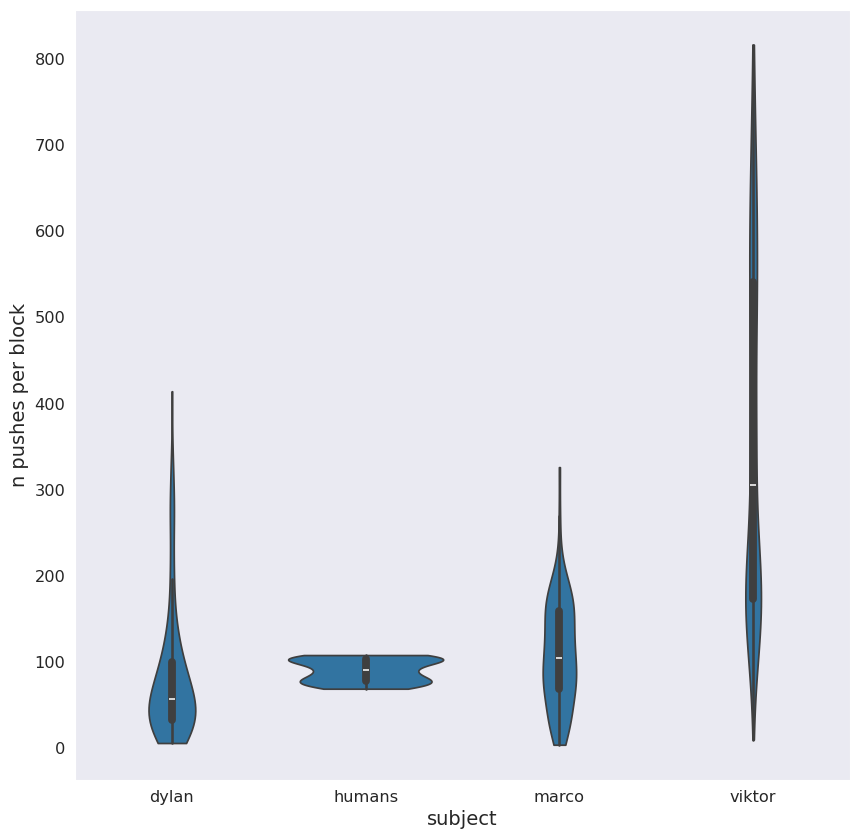

In [172]:
n_pushes_per_block = df.groupby(['subject', 'session', 'block']).size().reset_index(name='n pushes per block')
fig, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(n_pushes_per_block, x='subject', y='n pushes per block', cut=0, ax=ax)

In [173]:
summary = n_pushes_per_block.groupby('subject')['n pushes per block'].agg(['min', 'max', 'mean', 'std'])
print("summary of # pushes per block by subject")
print(summary)

summary of # pushes per block by subject
         min  max        mean         std
subject                                  
dylan      6  414   82.331325   76.635808
humans    69  108   90.238095   13.251433
marco      4  326  110.300971   61.397266
viktor    10  816  357.690691  204.248395


# Analyze Outliers

Before we get to the fun stuff of analyzing behavior, it is worth taking pains to clean the data by filtering out behavior that seems "off-task". This may seem counterproductive to the goal of analyzing free behavior, but there is a trade-off between the goals of modeling as much of the behavior as possible and having a simple model of a subset of "interesting" behavior. The goal of this notebook is to design a rudimentary exclusion criteria to isolate this subset of outliers. Intuitively, long bouts of time when the subject is not engaged with the task should be indicative of off-task behavior. This is a vague criterion that we will refine by exploring the distribution of consecutive push intervals, the times between consecutive pushes. Some of these push intervals will occur back-to-back at the same box, which we will refer to as the "stay pushes". Push intervals that start at one box and end at a different box will be referred to as "switch times". These include the transit time, which should be equal between all boxes as they are equidistant from each other, as well as any time spent between boxes to gather information. First, we'll analyze these two types of push intervals together, then separate them. There are multiple normative theories of foraging whose predictions we can compare our subject's data against, such as the matching law or marginal value theorem. After filtering the data, we will explore these predictions.

Text(40.000000000000014, 0.5, 'consecutive push intervals (s)')

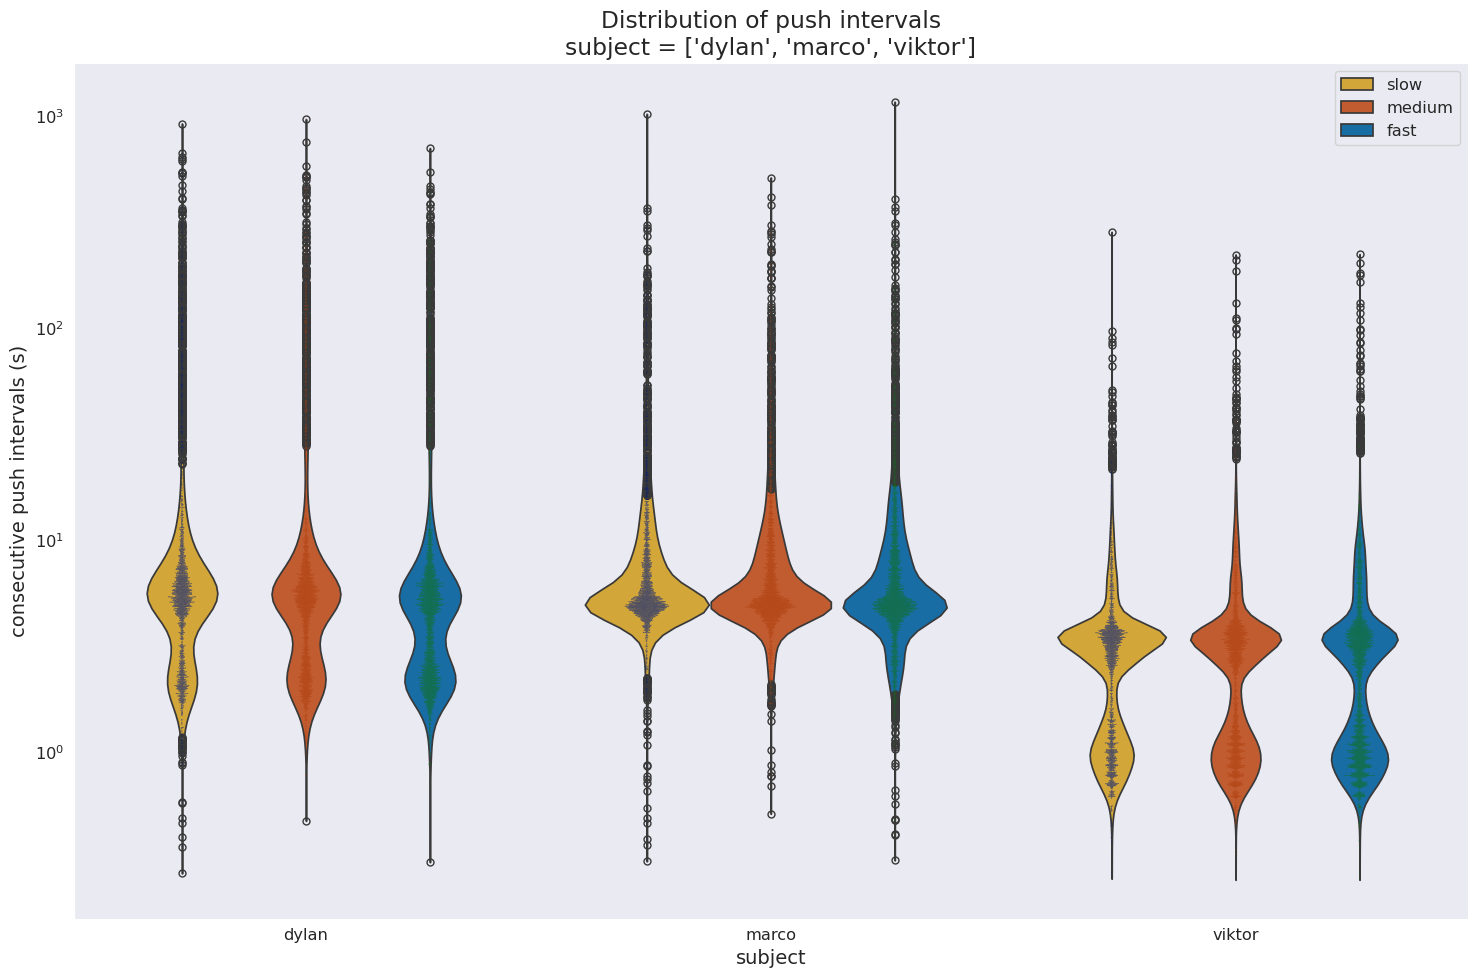

In [3]:
# Examine monkeys separately from humans
conds = {'subject': ['dylan', 'marco', 'viktor']}
df_monkey = utils.data.filter_df(df, conds).copy(deep=True)

# Plot distribution of push intervals on log-scale
fig, ax = plt.subplots()
bp(sns.boxplot)(df_monkey, conds=conds, x='subject', y='consecutive push intervals', collapse=True, showcaps=False,
                showbox=False, log_scale=True, whiskerprops={'visible': False}, medianprops={'visible': False},
                legend=False, ax=ax)
bp(sns.swarmplot)(df_monkey.groupby('subject').sample(10000, random_state=SEED), conds=conds, x='subject',
                  y='consecutive push intervals', collapse=True, legend=False, log_scale=True, size=0.5, dodge=True,
                  palette='dark', ax=ax)
bp(sns.violinplot)(df_monkey, conds=conds, x='subject', y='consecutive push intervals', collapse=True, cut=0,
                   inner=None, log_scale=True, common_norm=True, title_prefix="Distribution of push intervals", ax=ax)
ax.set_ylabel(ax.get_ylabel() + ' (s)')

Each monkey's push intervals are shown on a logscale, colored by the box that gets pushed at the end of the push interval. The individual circles are outliers that would show up on a boxplot of the data, defined as all datapoints lying outside of 1.5*IQR (inter-quartile range) from the first and third quartile (in the original data space, not log). Immediately it is obvious that one subject is not like the others-- Marco's data are pretty close to log-normal, with slightly faster pushes at the fast box compared to the other boxes. Dylan and Viktor exhibit a bimodality, where the larger mode most likely contains switch times and the smaller mode contains stay pushes that are proportionate to the speed of the boxes, which we will verify next.

Text(143.01116387261285, 0.5, 'stay pushes (s)')

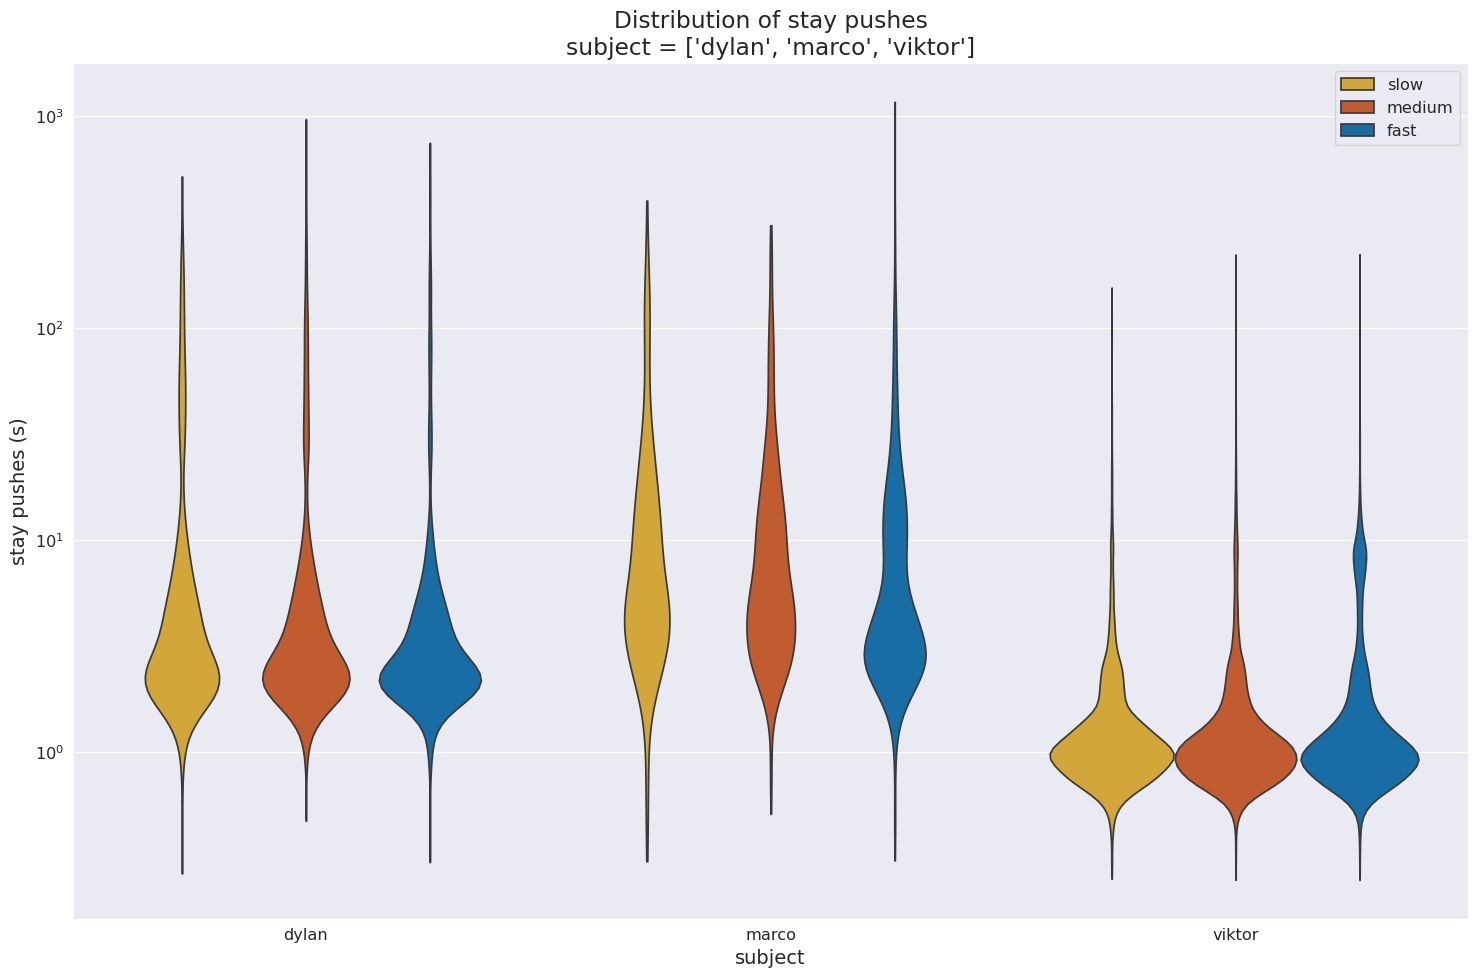

In [48]:
# Plot distribution of stay push intervals on log-scale
stay_pushes = utils.data.filter_df(df_monkey, {'stay/switch': False})
fig, ax = plt.subplots()
bp(sns.violinplot)(stay_pushes, conds=conds, x='subject', y='consecutive push intervals', common_norm=True,
                   collapse=True, cut=0, inner=None, log_scale=True, title_prefix="Distribution of stay pushes", ax=ax)
ax.set_ylabel("stay pushes (s)")

Text(143.13616387261285, 0.5, 'switch times (s)')

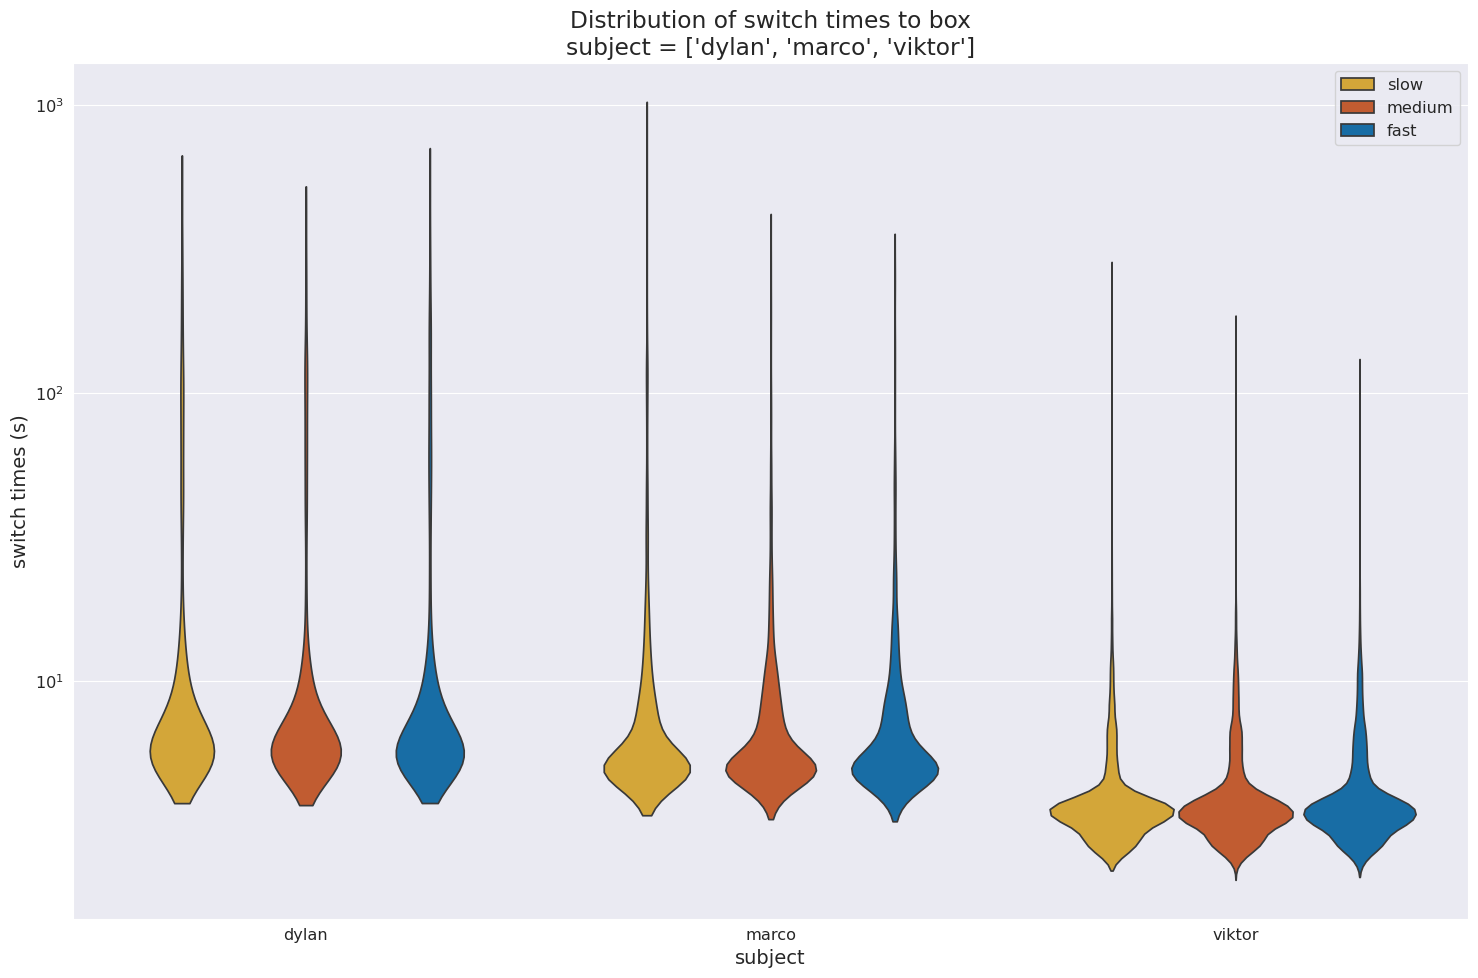

In [49]:
# Plot distribution of switch push intervals on log-scale
switch_times = utils.data.filter_df(df_monkey, {'stay/switch': True})
fig, ax = plt.subplots()
bp(sns.violinplot)(switch_times, conds=conds, x='subject', y='consecutive push intervals', collapse=True, cut=0,
                   inner=None, log_scale=True, common_norm=True, title_prefix="Distribution of switch times to box",
                   ax=ax)
ax.set_ylabel("switch times (s)")

 Indeed, we are able to decompose the bimodal consecutive pushes into switch times and stay pushes. For stay pushes, it appears Dylan and Marco push slightly slower than Viktor, and also their pushes are weakly ordered from fast --> medium --> slow. In contrast, Viktor seems to push at the same frequency of ~1 second across all three boxes, with a minor mode at the fast box emerging at 10 s. For switch times, it also appears that Viktor is the faster monkey, and all subjects have similar speeds between boxes. As a comparison, we consider the human data below.

Text(40.0, 0.5, 'consecutive push intervals (s)')

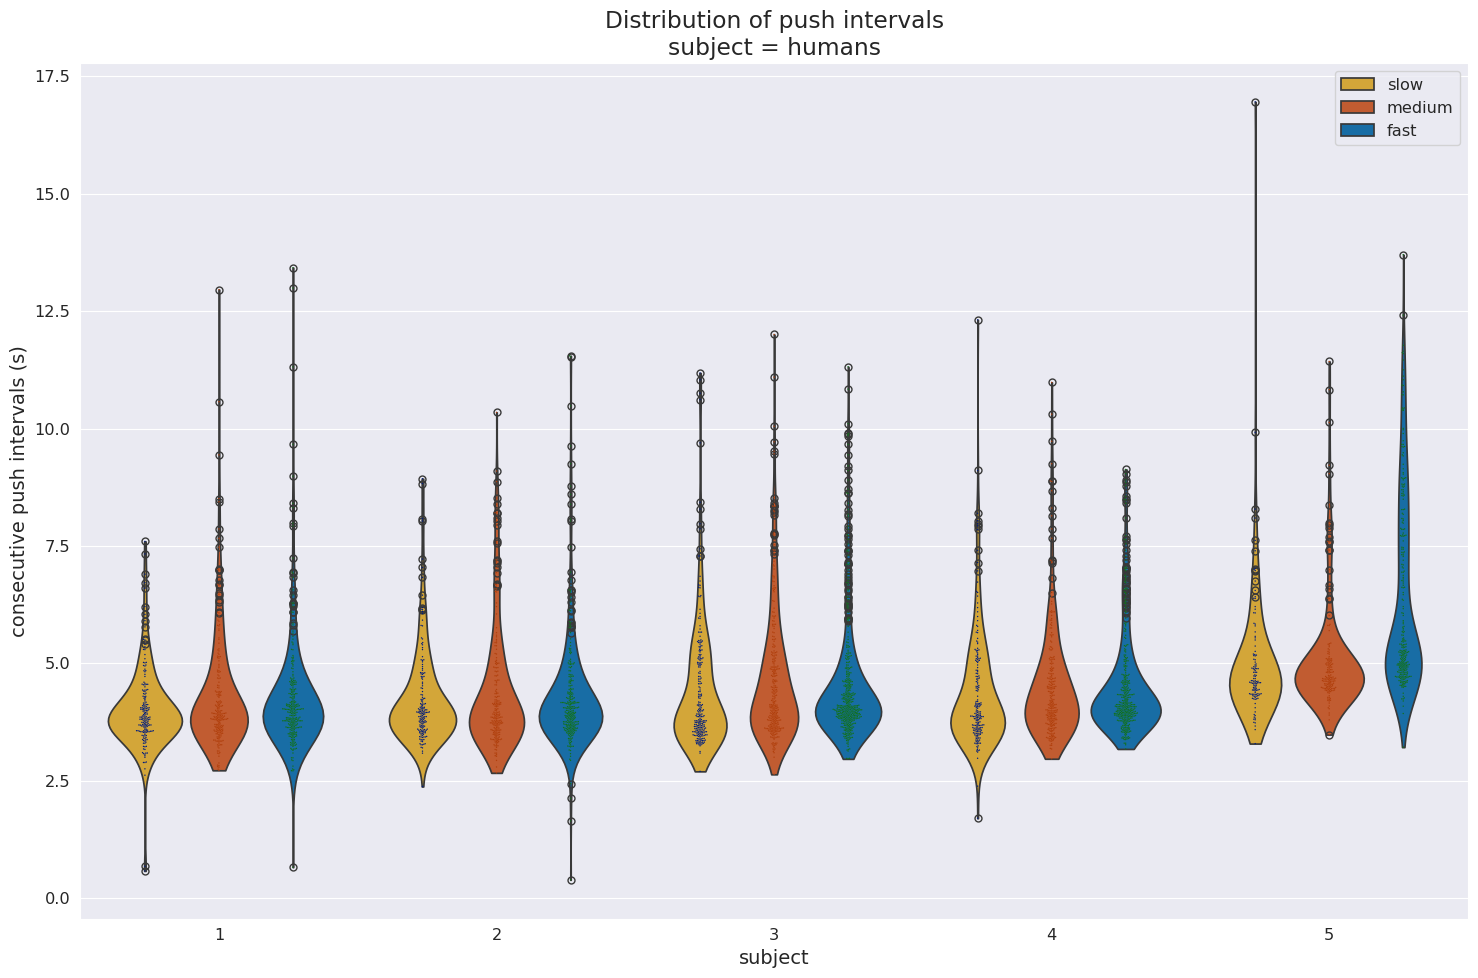

In [50]:
conds = {'subject': 'humans'}
df_human = utils.data.filter_df(df, conds)
fig, ax = plt.subplots()
bp(sns.boxplot)(df_human, conds=conds, x='session', y='consecutive push intervals', collapse=True, showcaps=False,
                showbox=False, whiskerprops={'visible': False}, medianprops={'visible': False}, legend=False, ax=ax)
bp(sns.swarmplot)(df_human, conds=conds, x='session', y='consecutive push intervals', collapse=True, legend=False,
                  size=1, dodge=True, palette='dark', ax=ax)
bp(sns.violinplot)(df_human, conds=conds, x='session', y='consecutive push intervals', collapse=True, cut=0, inner=None,
                   common_norm=True, title_prefix="Distribution of push intervals", ax=ax)
ax.set_xlabel('subject')
ax.set_ylabel(ax.get_ylabel() + ' (s)')

The human data are plotted on normal scale, and it's evident how different they are from the monkeys-- all monkeys share large outliers that we will design an exclusion criteria for, with Viktor having the smallest outliers. In contrast, the human data are more unimodal and exhibit far fewer outliers, although this could be due to the humans having much less data. Subject 5 seems to stand out compared to the rest.

Next, we will sort each push interval by the percentile at which it occurs in each subject's data and identify the knee in each curve, which marks the boundary when the data turns into extreme values.

dylan's elbow point & percentile: (21.248999999836087, 0.9089161614668047)
marco's elbow point & percentile: (34.280999999988126, 0.9609375)
viktor's elbow point & percentile: (10.305000000051223, 0.980442835494191)


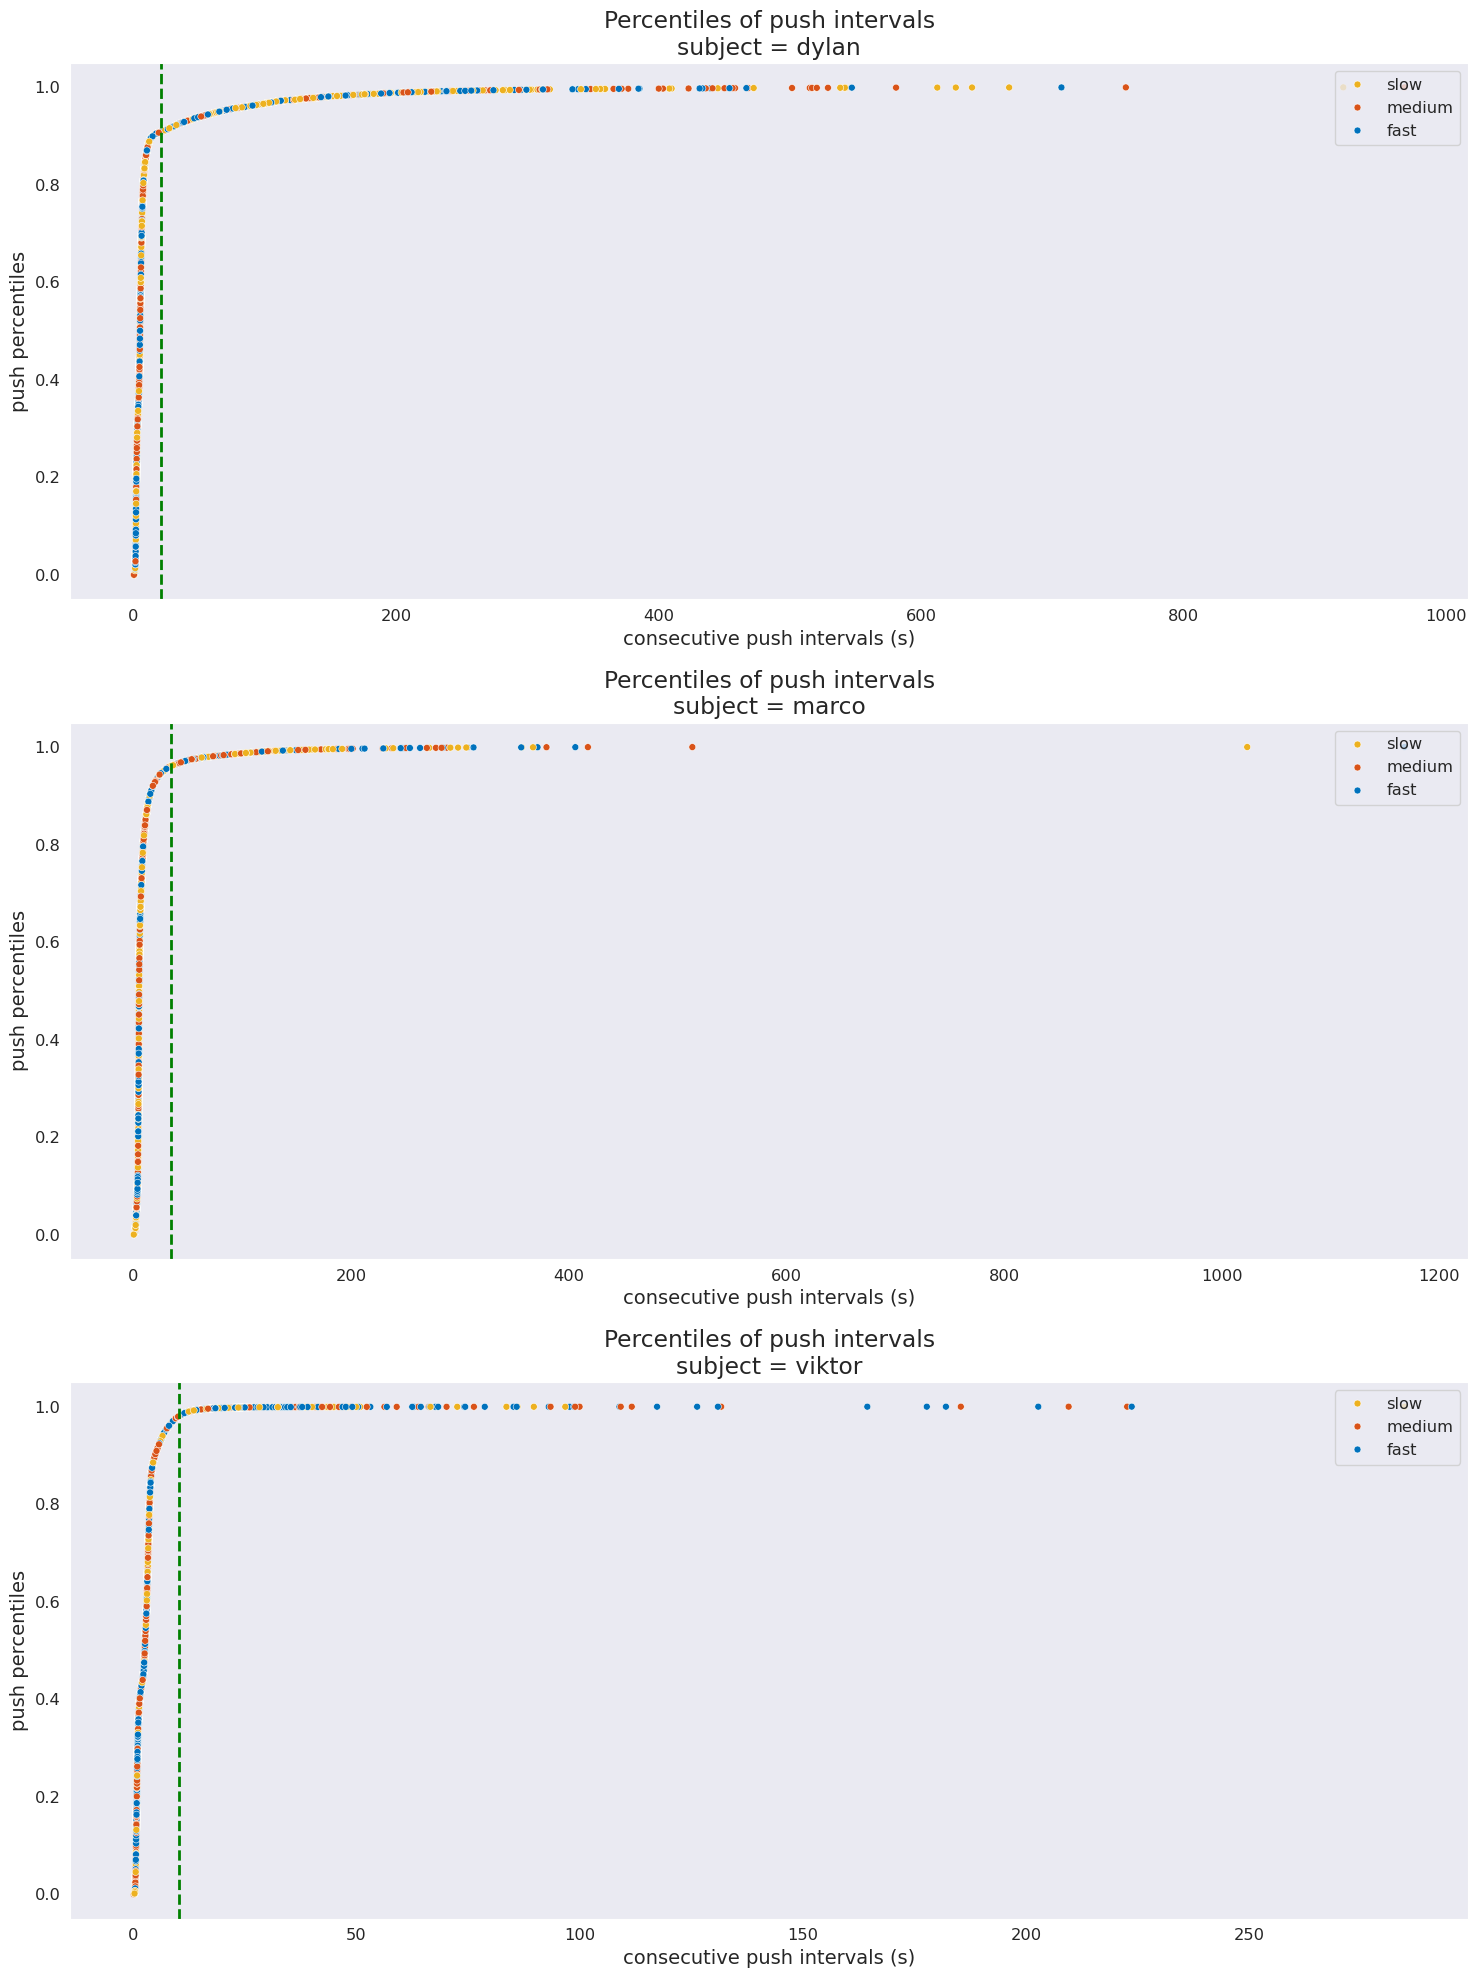

In [4]:
df_monkey['push percentiles'] = df_monkey.groupby('subject', as_index=False)['consecutive push intervals'].rank(
    pct=True)
monkey_subjects = df_monkey.index.unique('subject')
monkey_knees = {}
fig, axes = plt.subplots(len(monkey_subjects), 1, figsize=(15, 20))
for i, subj in enumerate(monkey_subjects):
    bp(sns.scatterplot)(df_monkey, x='consecutive push intervals', y='push percentiles', collapse=True,
                        conds={'subject': subj}, title_prefix="Percentiles of push intervals", ax=axes[i])
    y = df_monkey.loc[(subj,), 'push percentiles'].sort_values()
    x = df_monkey.loc[(subj,), 'consecutive push intervals'].sort_values()
    knee, perc, params, _ = plotting.plot_elbow(x, y, ax=axes[i], color='g', linestyle='--', label='elbow')
    monkey_knees[subj] = {
        'knee': knee,
        'perc': perc
    }
    print(f"{subj}'s elbow point & percentile: ({knee}, {perc})")
    axes[i].set_xlabel(axes[i].get_xlabel() + ' (s)')
fig.tight_layout()

The knee emerges at different points for each subject: for Dylan, this is at the 90th percentile, for Marco at the 96th, and for Viktor at the 98th. Notice how for Marco this corresponds to a push interval of ~34 s, meanwhile for the other two the knees occur at much smaller push intervals as low as ~10 s, which are comparable to the schedules used in the task spanning 15 s - 35 s. A good threshold that doesn't exclude potentially interesting behavior should be less conservative than these knees. To get a better sense of an appropriate boundary, we will consider example blocks containing the highest percentile of pushes.

## Example Blocks


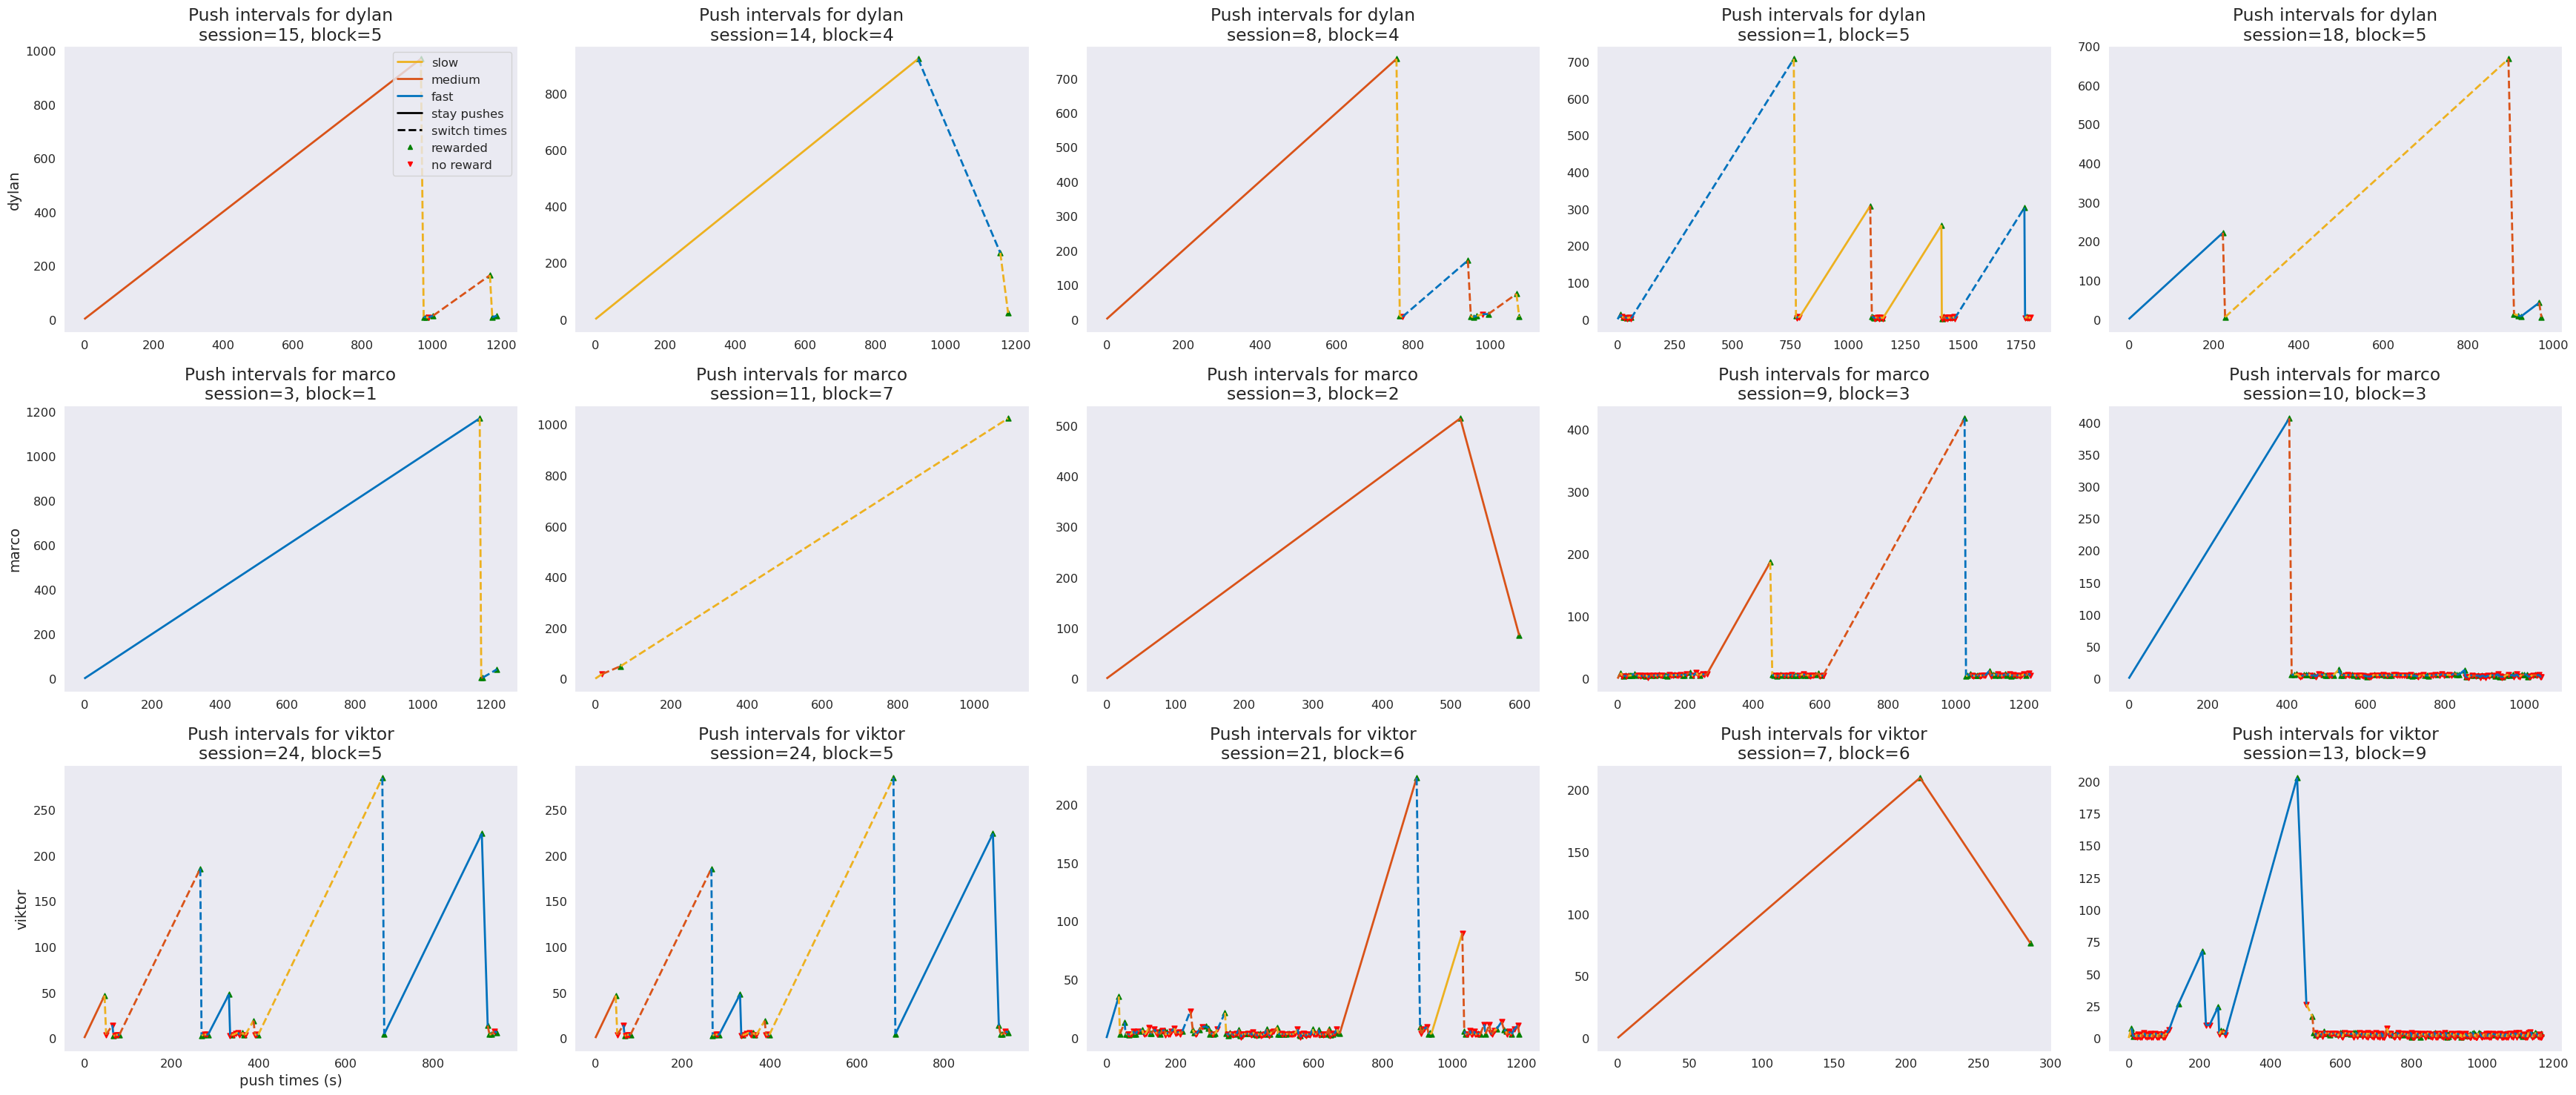

In [7]:
df_sorted = df_monkey.sort_values(by='consecutive push intervals', ascending=False)
n_pushes_per_block = 5
fig, axes = plt.subplots(len(monkey_subjects), n_pushes_per_block, figsize=(35, 15))
for i, subject in enumerate(monkey_subjects):
    df_block = utils.data.filter_df(df_sorted, {'subject': subject})[:n_pushes_per_block]
    for j, block in enumerate(df_block.itertuples()):
        plotting.behavior.plot_push_intervals(df_monkey.loc[(block[0][0], block[0][1], block[0][2])],
                                              title=f'Push intervals for {block[0][0]}\nsession={block[0][1]}, block={block[0][2]}',
                                              legend=i + j == 0, ax=axes[i, j])
        if not i * n_pushes_per_block + j == 2 * n_pushes_per_block:
            axes[i, j].set_xlabel("")
            axes[i, j].set_ylabel("")
        else:
            axes[i, j].set_xlabel(axes[i, j].get_xlabel() + ' (s)')
        if j == 0:
            axes[i, j].set_ylabel(subject)
fig.tight_layout()

Here are the blocks that contain the top outliers for each subject. Each push is labeled by its reward outcome, with the green caret indicating reward and the red indicating no reward. Notice how sparse some of these blocks are, while others feature long segments of spam pushes punctuated by long intervals where the monkey doesn't push anywhere. One consideration for the exclusion criteria is to drop blocks that contain fewer than x pushes e.g. 10 pushes, because the one or two "reasonable looking" pushes in these blocks don't necessarily mean the monkey was actually engaged with the task; instead it's very likely the animal is actually disengaged with the task the entirety of that block, thus nullifying any reasonable appearing behavior in that block. Next, we will consider temporal and spatial dimensions of the data. First, we'll show the distribution of push intervals as a function of sessions experienced by each subject, then we will ask if there is a correlation between push intervals and spatial variables, such as position and eye tracking.

## Time

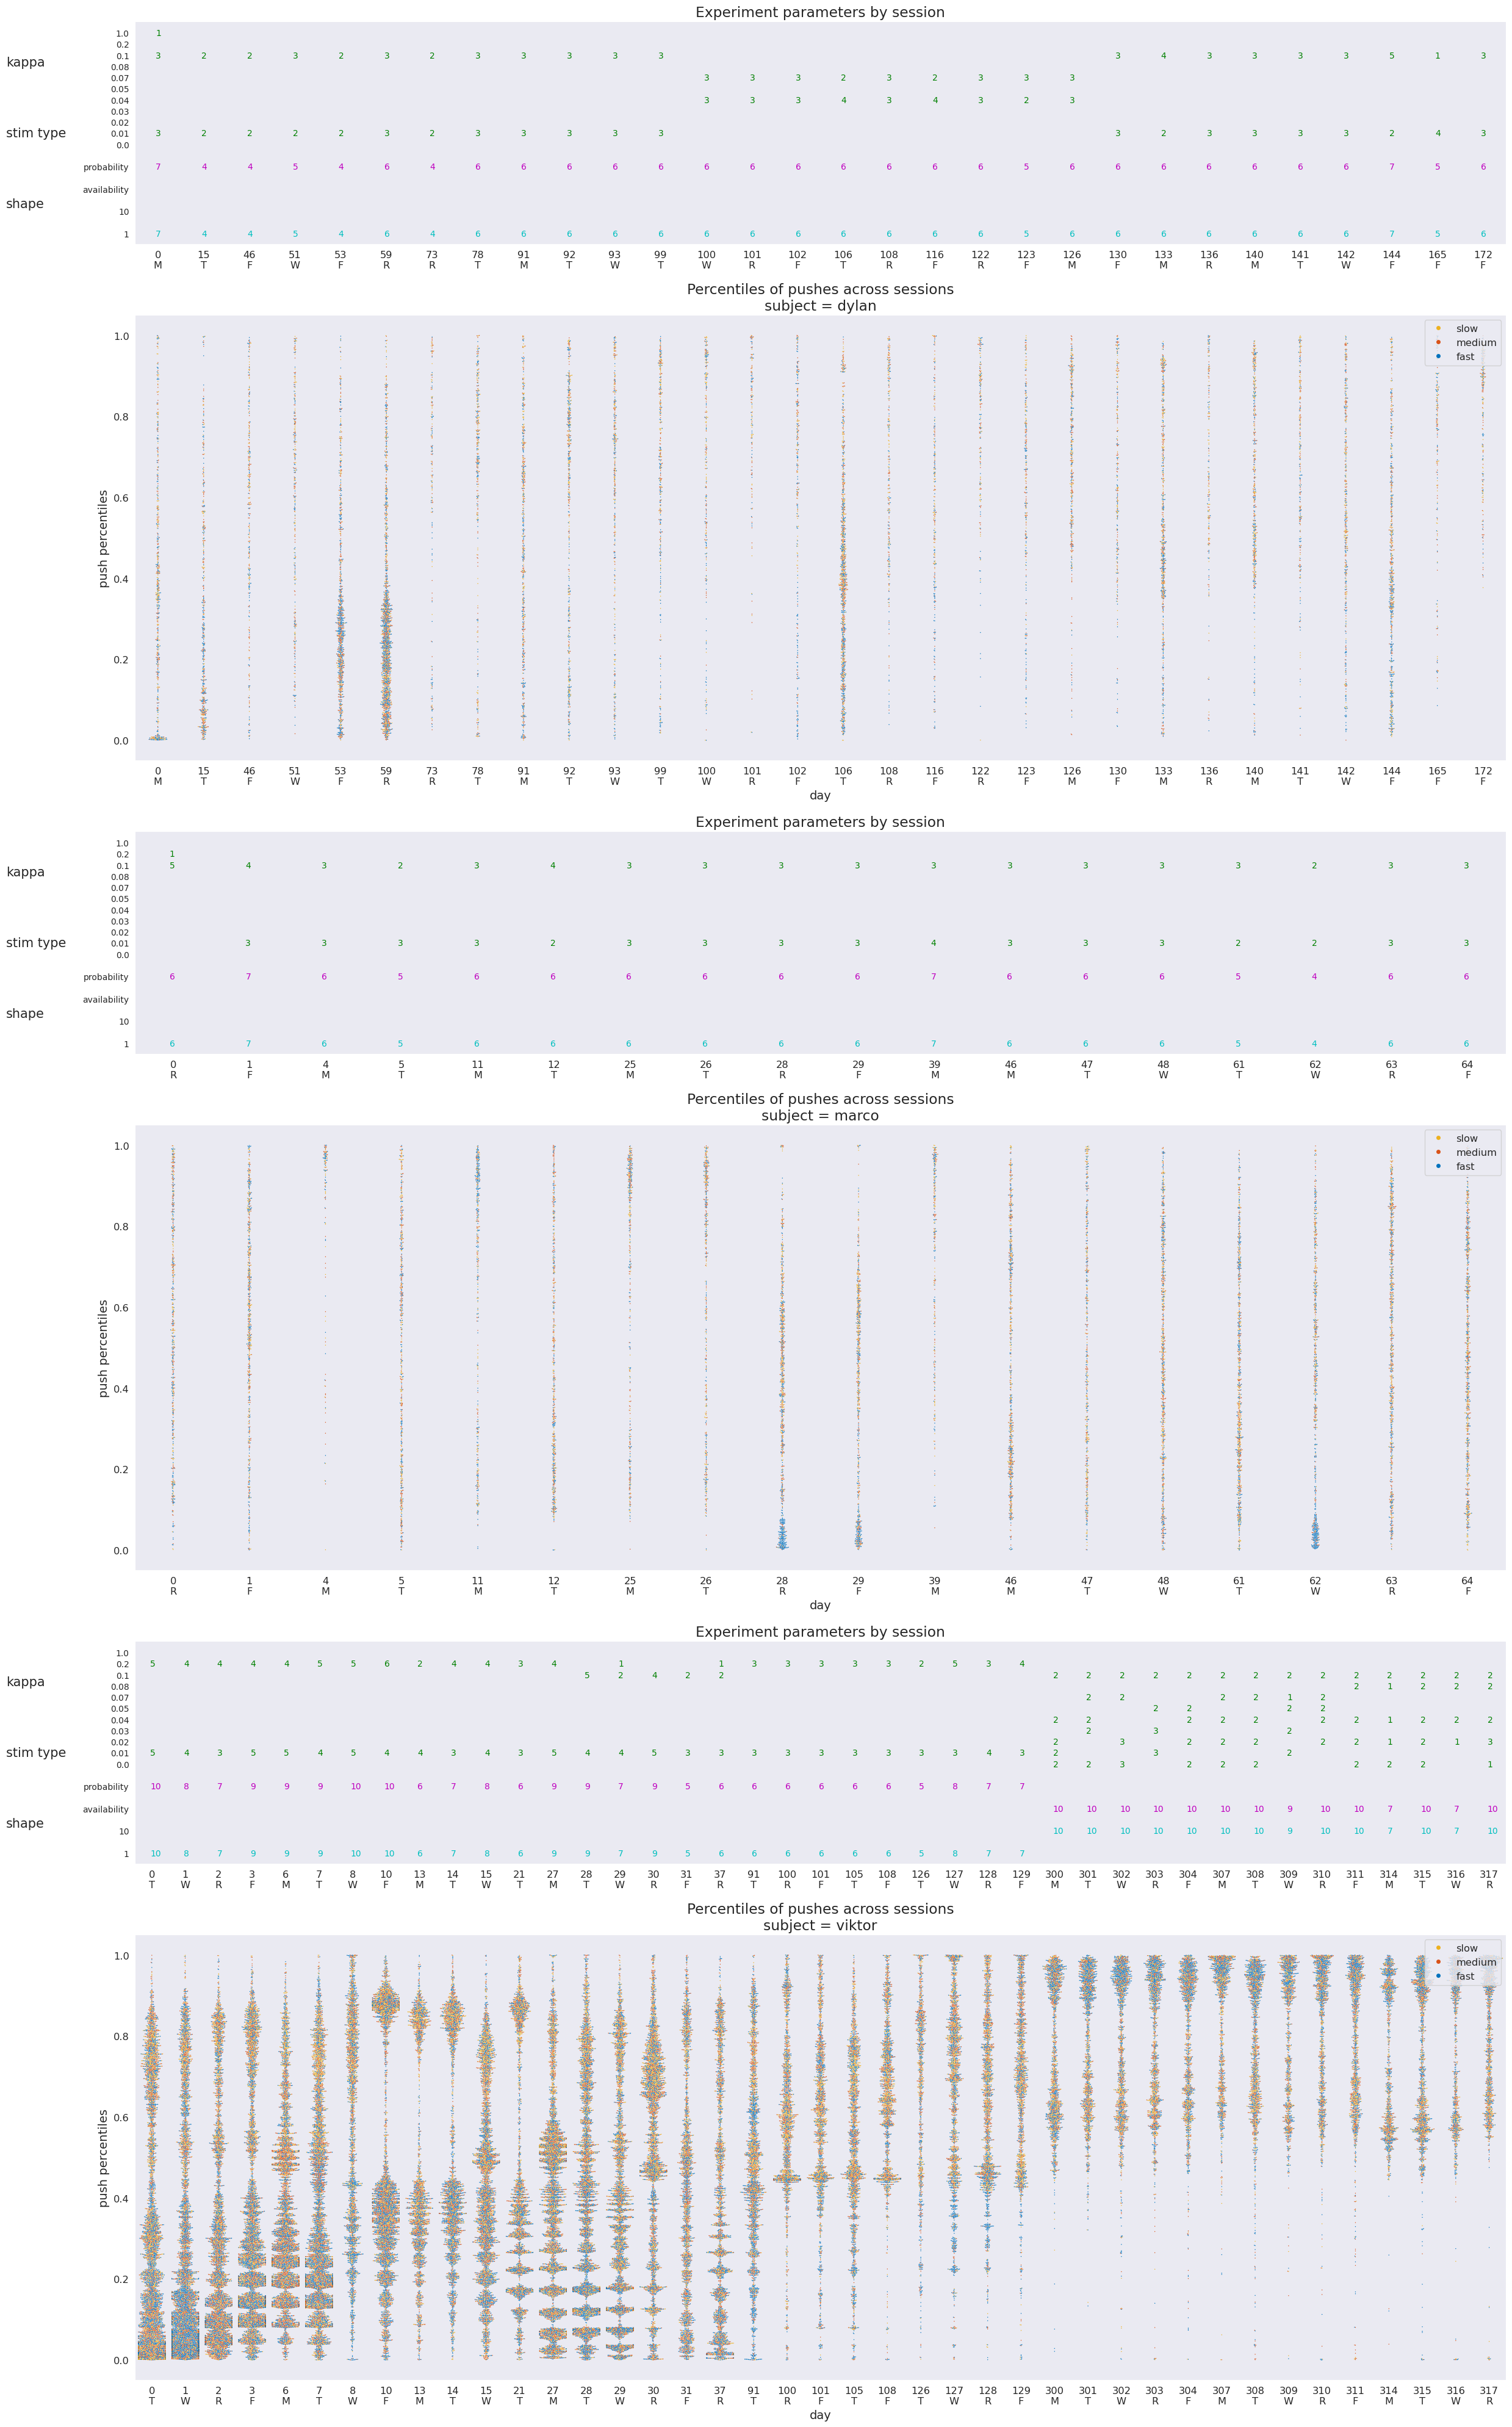

In [8]:
%%capture --no-display
# Reformat time data
df_monkey['session id'] = pd.to_datetime(df_monkey['session id'], format='%Y%m%d')
df_ref = df_monkey.groupby('subject')['session id'].min()
df_monkey = df_monkey.join(df_ref, how='left', rsuffix='_ref', on=['subject'])
df_monkey['day'] = (df_monkey['session id'] - df_monkey['session id_ref']).dt.days
fig, axes = plt.subplots(len(monkey_subjects) * 2, 1, figsize=(25, 40), height_ratios=[1, 2] * len(monkey_subjects))
for i, subj in enumerate(monkey_subjects):
    plotting.behavior.plot_experiment_parameters(df_monkey, conds={'subject': subj}, ax=axes[2 * i])
    bp(sns.swarmplot)(df_monkey, x="day", y="push percentiles", collapse=True, conds={'subject': subj},
                      title_prefix="Percentiles of pushes across sessions", size=1,
                      legend_kwargs={'markerscale': 5, 'loc': 'upper right'}, ax=axes[2 * i + 1])

    # Add weekday labels
    labels = axes[2 * i + 1].get_xticklabels()
    days = df_monkey.xs(subj, level='subject').reset_index().groupby(['session'], as_index=False)['week day'].max()[
        'week day']
    for j, l in enumerate(labels):
        tmp = l.get_text()
        labels[j] = tmp + '\n' + days[j]
    axes[2 * i + 1].set_xticklabels(labels)

    # Align x-axis
    axes[2 * i].sharex(axes[2 * i + 1])
fig.tight_layout()

These swarm plots are useful for visualizing individual data points by jittering the ones that collide, to the limit that the data points aren't too cluttered and impede comprehension. The x-axis denotes days since the first session (with day 0 corresponding to the first session) and the y-axis are the ranks/percentiles of each push in each session. For Dylan and Marco, the number of data points is manageable but for Viktor they are so numerous that you can see where the plot struggles to fit all the data points. Each swarm plot is preceded by an experiment overview where for each session we denote how many blocks had a certain experiment parameter, which gives us a sense of the timeline for how the experiment evolved and when decisions were made to change the experiment. The x-axes for a swarm plot and its corresponding experiment overview are aligned for ease of comparison.

This figure lets us see how many pushes occur in each session as well as how those pushes are distributed compared to the entire dataset for a given subject. One thing to look for are sessions where the distribution favors large percentiles, for example, day 0 for Dylan shows a bump around extremely low percentiles and days 53-59 contain a lot of pushes that occur in the bottom 50% of all pushes for that subject. For Marco, day 4 is extremely scarce in pushes compared to other days, and the pushes that do occur are very high percentile, so we would expect this session to contain a lot of off-task behavior.

It's interesting to see heterogeneous patterns in the pushes, in particular for Viktor. In fact, we see three distinct patterns of clusters: on days 100-129, we see the pushes across the boxes tend to be in the upper 40%, and on day 300 (session 28) onwards the pushes occupy the top 50% and distributionally look different from the rest of the data. These groups seem to roughly line up with different time periods in which the animal did the experiment, where the first group boundary emerges between day 37 and 91 (a difference of almost 2 months) and the second group boundary emerges between day 129 and 300 (a difference of almost 6 months!). Within the first group, there are even sub-groups that emerge on days 0-8, 10 - 21, 27 - 37. In the next section, we turn our attention to position and eye tracking.

## Space
### 3D Position

Below is an example block containing long periods of time where Marco does not push at a box and his corresponding 3D position in the arena over time. The block contains a couple push intervals ie. between 700-800 seconds in the trial that take as long as a few hundred seconds, which translates to minutes not engaging with the task. The 3D plot of the position trajectory encodes time as color, and by eye we can see that between 700-800 seconds the monkey climbed up in the arena and hung around for some time before descending down to push. The units for position are in mm.

(<Axes3D: title={'center': '3D Position of monkey'}>,
 <mpl_toolkits.mplot3d.art3d.Path3DCollection at 0x7fa5e543b1c0>)

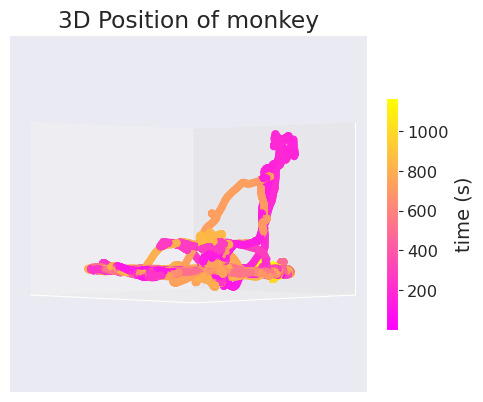

In [21]:
continuous_data, errors = utils.data.get_continuous_from_df_to_dict(df_monkey, EXPERIMENT_DIR)
plotting.behavior.plot_continuous3d_dict(continuous_data, [('marco', 13, 6)], x='position',
                                         title="3D Position of monkey", plt_kwargs={'cmap': 'spring'},
                                         cbar_kwargs={'shrink': 0.7, 'fraction': 0.03, 'label': 'time (s)'},
                                         fig_kwargs={'figsize': (5, 5)})

Now we aggregate position data over multiple blocks below. First, we evenly sample pushes from all percentiles in a subject's data to ensure a fair representation of the positions occupied during these pushes. Then we plot the 3D coordinates of the positions occupied during these sampled push intervals and color them by the time that's passed since the last push.

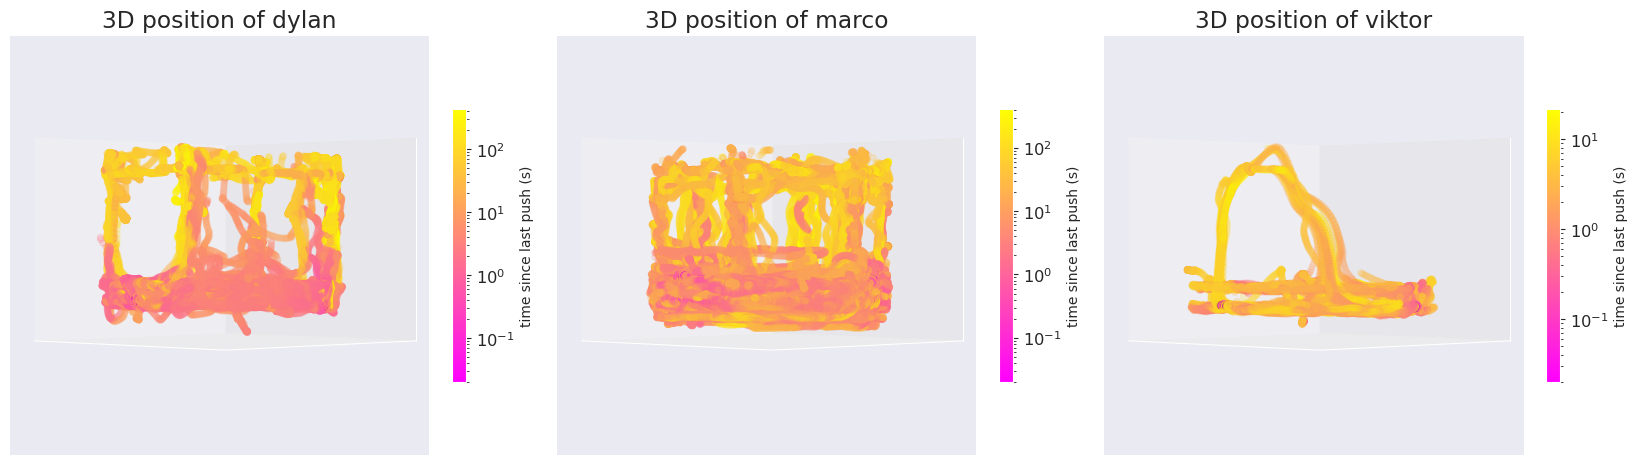

In [22]:
def filter_percentiles(df, p, n):
    subset = df.loc[(df['push percentiles'] >= p[0]) & (df['push percentiles'] <= p[1])]
    n = min(n, len(subset))  # Prevent errors if n > len(df)
    return subset.sample(n)


# Evenly sample pushes from each percentile bracket
n_samples = 1000
percentiles = zip(np.arange(0, 1, 0.2), np.arange(0.2, 1.2, 0.2))
perc_dfs = []
for p in percentiles:
    perc_dfs.append(df_sorted.groupby('subject', group_keys=False).apply(filter_percentiles, p=p, n=n_samples))
all_perc_df = pd.concat(perc_dfs)

# Plot each push's 3d position data as a function of time since the start of the push
fig = plt.figure(figsize=(20, 10))
cbars = []
for i, subject in enumerate(monkey_subjects):
    df_subj = utils.data.filter_df(all_perc_df, {'subject': subject})
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    _, p = plotting.behavior.plot_continuous3d_df(df_subj, continuous_data, 'position',
                                                  title=f'3D position of {subject}',
                                                  plt_kwargs={'alpha': 0.2, 'cmap': 'spring', 'norm': LogNorm()},
                                                  cbar_kwargs={'shrink': 0.7, 'fraction': 0.03, 'alpha': 1}, ax=ax)
    p.colorbar.set_label(p.colorbar.ax.get_ylabel(), fontsize=10)
    cbars.append(p.colorbar)

Across all subjects, there is a clear correlation between the vertical position occupied by the subject and the length of the push interval-- longer push intervals are associated with climbing around the arena more. To see this more clearly, we replot the data for the top 10% of pushes separately from the rest.

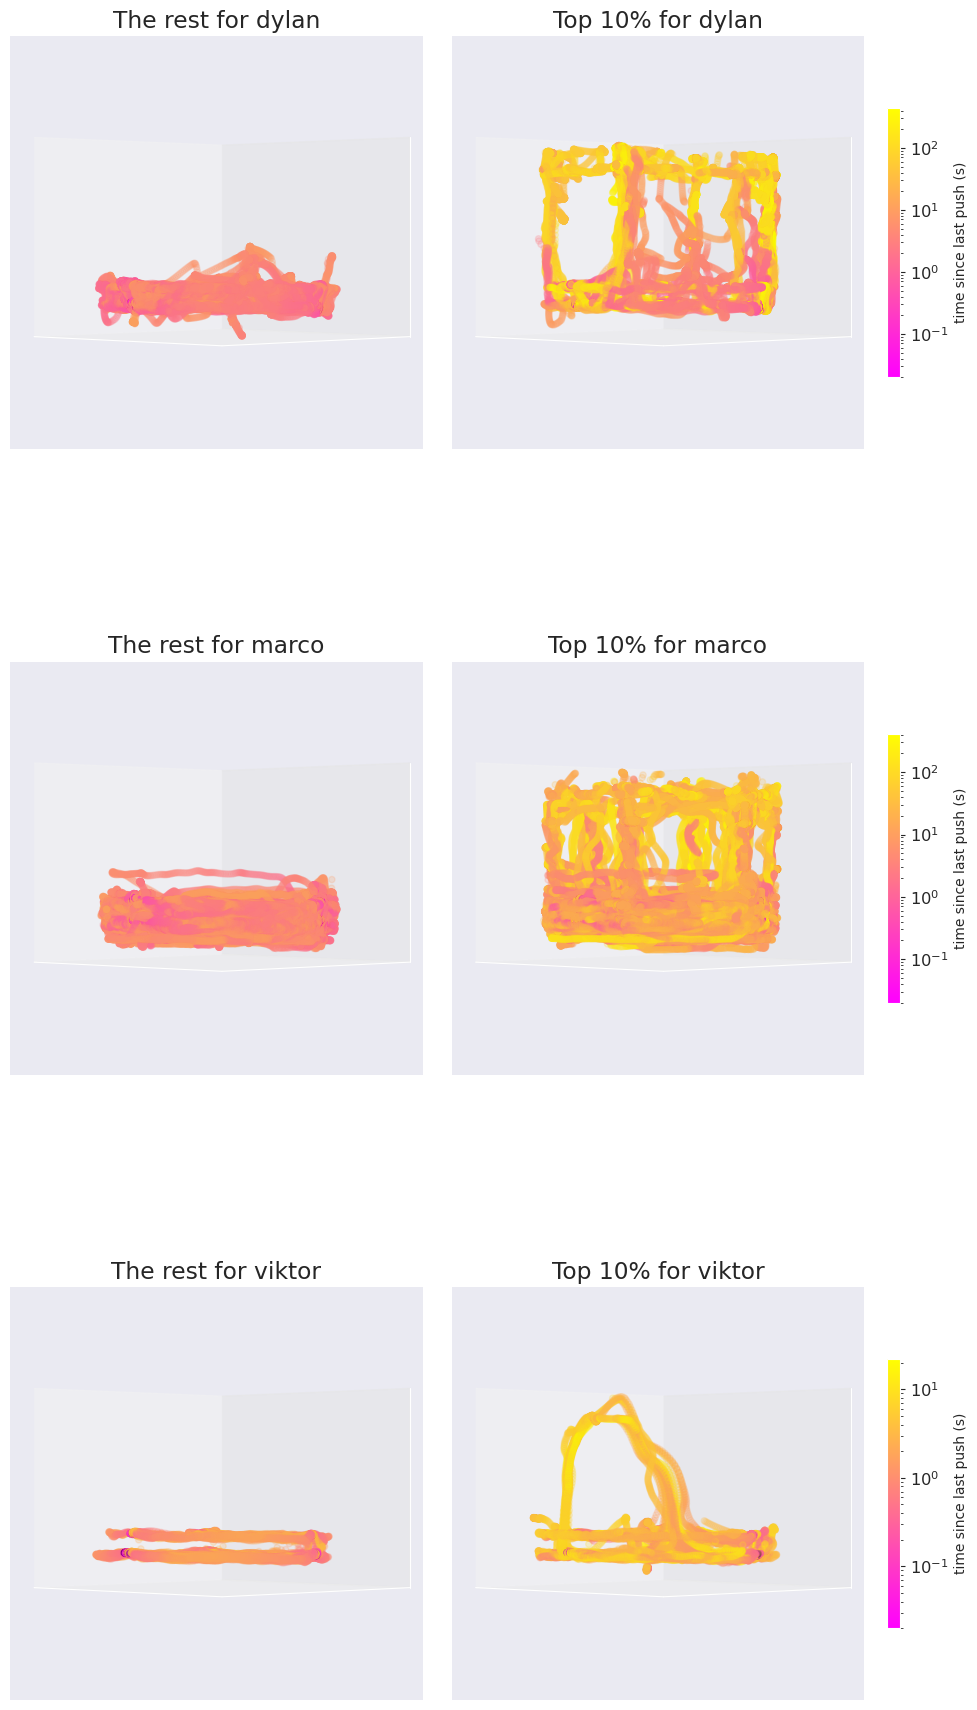

In [23]:
fig = plt.figure(figsize=(10, 20))
for i, subject in enumerate(monkey_subjects):
    df_subj = utils.data.filter_df(all_perc_df, {'subject': subject})

    # The rest
    ax = fig.add_subplot(3, 2, 2 * i + 1, projection='3d')
    ax1, p1 = plotting.behavior.plot_continuous3d_df(df_subj[df_subj['push percentiles'] < 0.9], continuous_data,
                                                     'position', title=f'The rest for {subject}',
                                                     plt_kwargs={'alpha': 0.2, 'cmap': 'spring', 'norm': LogNorm()},
                                                     cbar_kwargs={'shrink': 0.7, 'fraction': 0.03, 'alpha': 1}, ax=ax)
    c1 = p1.colorbar

    # Top 10%
    ax = fig.add_subplot(3, 2, 2 * i + 2, projection='3d', sharex=ax, sharey=ax, sharez=ax)
    ax2, p2 = plotting.behavior.plot_continuous3d_df(df_subj[df_subj['push percentiles'] >= 0.9], continuous_data,
                                                     'position', title=f'Top 10% for {subject}',
                                                     plt_kwargs={'alpha': 0.2, 'cmap': 'spring', 'norm': LogNorm()},
                                                     cbar_kwargs={'shrink': 0.7, 'fraction': 0.03, 'alpha': 1}, ax=ax)
    c2 = p2.colorbar
    c2.set_label(c2.ax.get_ylabel(), fontsize=10)

    # Modify colors to be on the same scale post-hoc
    vmin = cbars[i].norm.vmin
    vmax = cbars[i].norm.vmax
    p1.set_clim(vmin, vmax)
    p2.set_clim(vmin, vmax)

    # Do this to preserve spatial layout
    c1.ax.set_visible(False)
fig.tight_layout()

Now that they are separated, we can clearly see that whenever the monkey spends time climbing, these are associated with the monkey taking the most time between pushes. Notably, Viktor engages in this behavior the least, displaying one vertical arc, and overall has shorter push intervals. What is unclear is whether these trajectories reflect a monkey in motion on its way to a box, or a relaxed monkey not engaging with the task. To resolve this, one would need to consider the velocity at each position, which we leave for future work.

### 2D Position

We also consider the positions occupied while on the floor, which are defined as when the vertical z-coordinate falls below 500 mm, the height of the boxes.

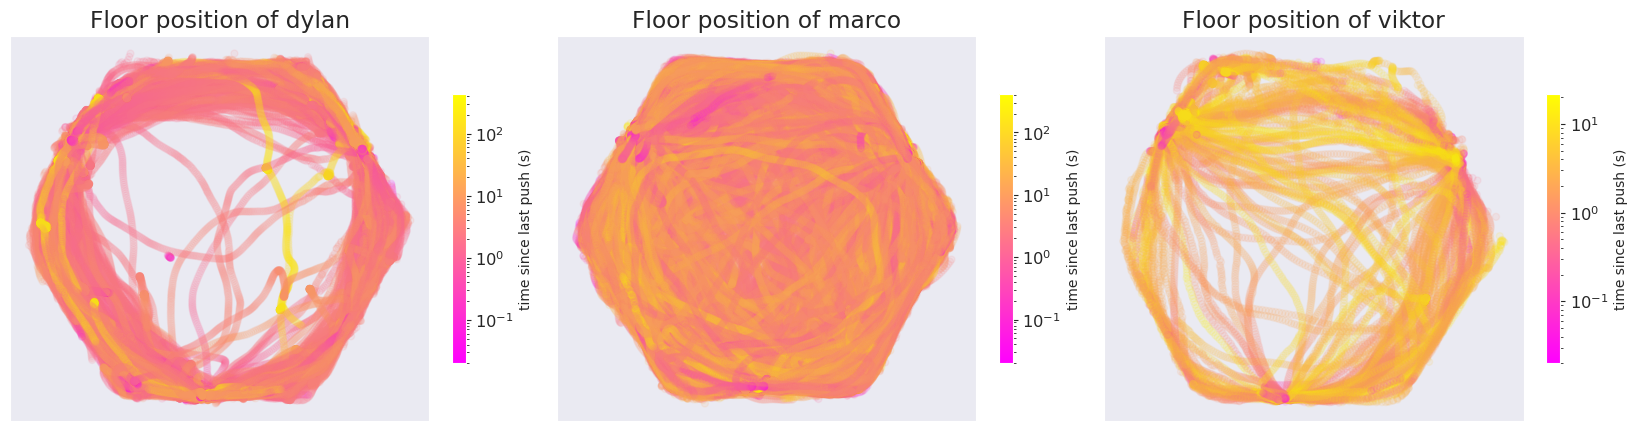

In [24]:
continuous_data_floor = {}
for k, v in continuous_data.items():
    idx = v['position'][:, 2] < 500
    continuous_data_floor[k] = {}
    for k1, v1 in v.items():
        if isinstance(v1, dict):
            continuous_data_floor[k][k1] = {k2: v2[idx] for k2, v2 in v1.items()}
        else:
            continuous_data_floor[k][k1] = v1[idx]

# Plot each push's 2d position data as a function of time since the start of the push
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, subject in enumerate(monkey_subjects):
    df_subj = utils.data.filter_df(all_perc_df, {'subject': subject})
    _, p = plotting.behavior.plot_continuous2d_df(df_subj, continuous_data_floor, 'position',
                                                  title=f'Floor position of {subject}',
                                                  plt_kwargs={'alpha': 0.1, 'cmap': 'spring', 'norm': LogNorm()},
                                                  cbar_kwargs={'shrink': 0.7, 'fraction': 0.03, 'alpha': 1}, ax=ax[i])
    p.colorbar.set_label(p.colorbar.ax.get_ylabel(), fontsize=10)

Dylan seems to avoid the center, keeping to the edge of the arena while Marco moves all over the place. Viktor seems to avoid some of the center to a lesser extent.

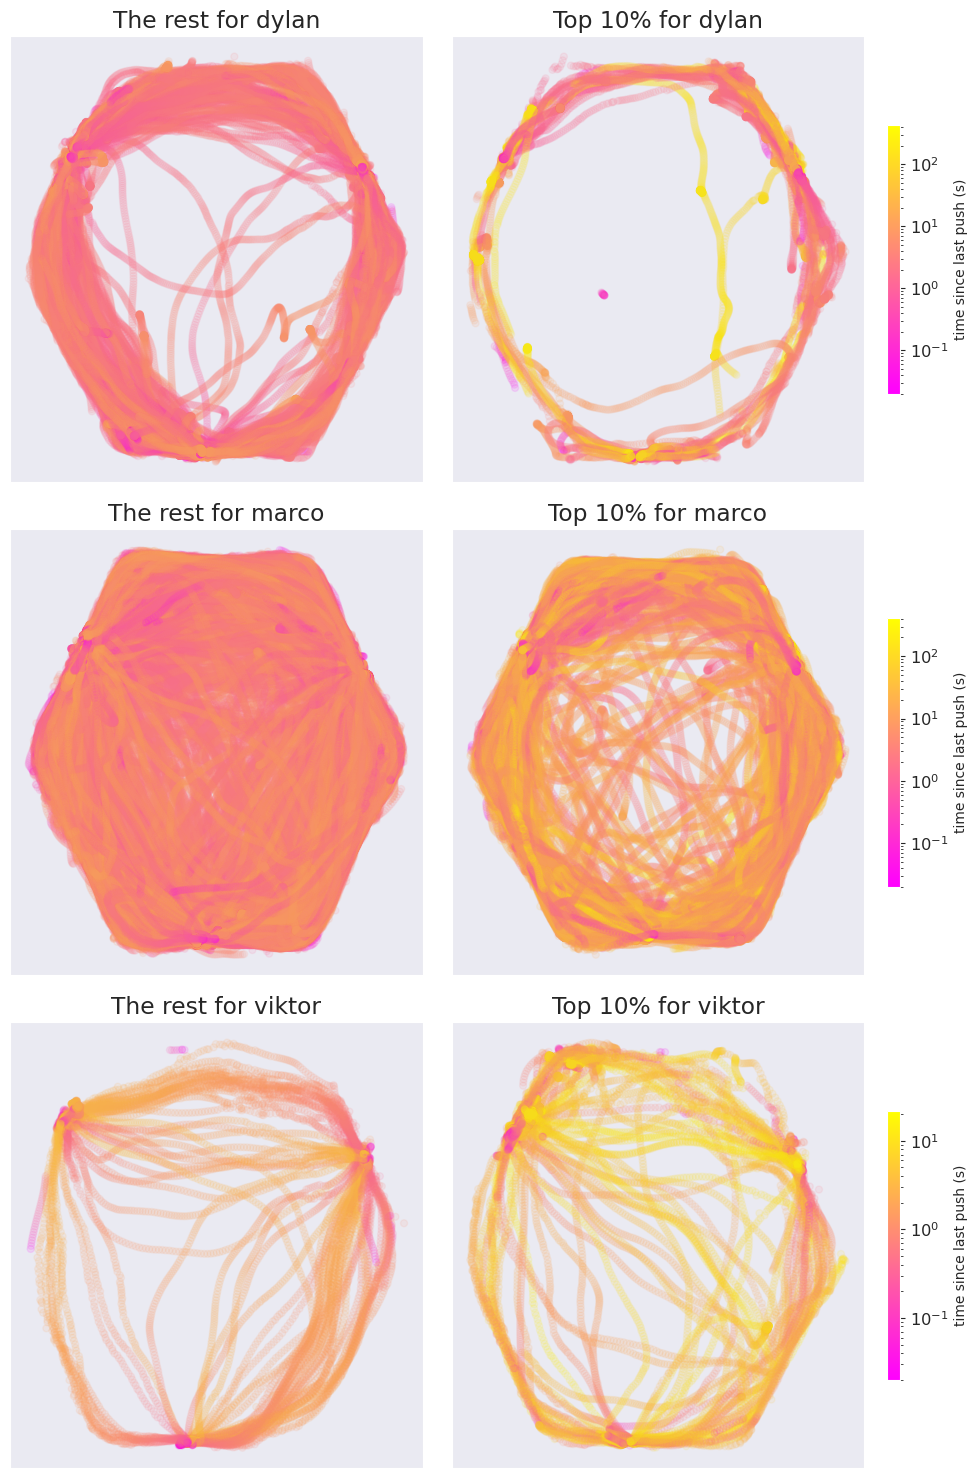

In [25]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for i, subject in enumerate(monkey_subjects):
    df_subj = utils.data.filter_df(all_perc_df, {'subject': subject})

    # the rest
    ax1, p1 = plotting.behavior.plot_continuous2d_df(df_subj[df_subj['push percentiles'] < 0.9], continuous_data_floor,
                                                     'position', title=f'The rest for {subject}',
                                                     plt_kwargs={'alpha': 0.1, 'cmap': 'spring', 'norm': LogNorm()},
                                                     cbar_kwargs={'shrink': 0.7, 'fraction': 0.03, 'alpha': 1},
                                                     ax=ax[i][0])
    c1 = p1.colorbar
    c1.set_label(c1.ax.get_ylabel(), fontsize=10)

    # top 10%
    ax2, p2 = plotting.behavior.plot_continuous2d_df(df_subj[df_subj['push percentiles'] >= 0.9], continuous_data_floor,
                                                     'position', title=f'Top 10% for {subject}',
                                                     plt_kwargs={'alpha': 0.1, 'cmap': 'spring', 'norm': LogNorm()},
                                                     cbar_kwargs={'shrink': 0.7, 'fraction': 0.03, 'alpha': 1},
                                                     ax=ax[i][1])
    c2 = p2.colorbar
    c2.set_label(c2.ax.get_ylabel(), fontsize=10)

    # Modify colors to be on the same scale post-hoc
    vmin = c2.norm.vmin
    vmax = c2.norm.vmax
    p1.set_clim(vmin, vmax)

    # Do this to preserve spatial layout
    c1.ax.set_visible(False)
fig.tight_layout()

It seems that when Dylan takes an exceptionally long time between pushes, he sticks even closer to the edge. Viktor and Marco also seem to move through the center slightly less on his longer pushes.

### 3D Eye Tracking
Based on the position data, one would expect there to be some correlation between where the monkey is and where it is looking. Below we plot the 3D coordinates of the eye tracking data and color each point by the percentile of the push interval that the eye tracking occurs in.

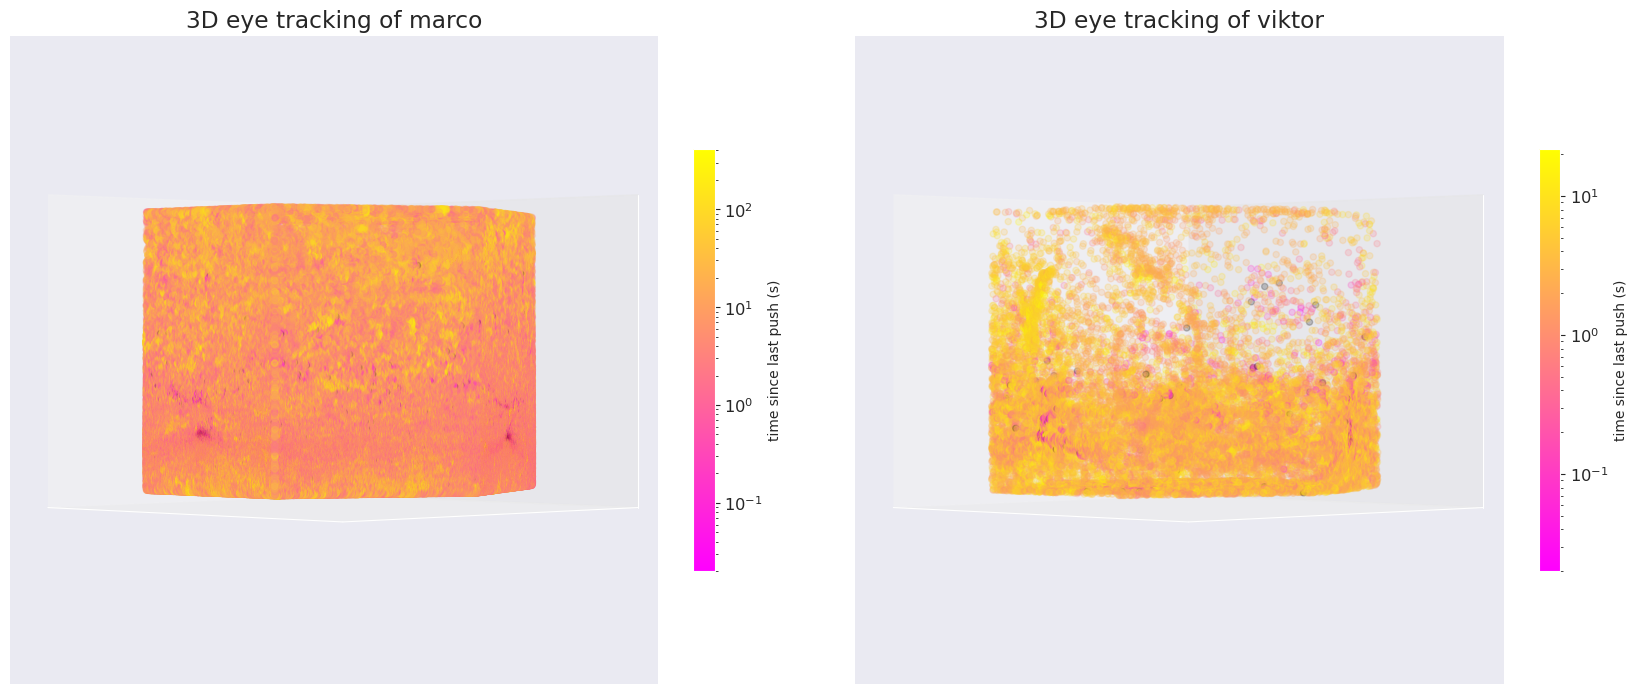

In [26]:
monkey_subjects_eye_tracking = ['marco', 'viktor']
fig = plt.figure(figsize=(20, 10))
for i, subject in enumerate(monkey_subjects_eye_tracking):
    df_subj = utils.data.filter_df(all_perc_df, {'subject': subject})
    ax = fig.add_subplot(1, 2, i + 1, projection='3d')
    _, p = plotting.behavior.plot_continuous3d_df(df_subj, continuous_data, 'eye_arena_int',
                                                  title=f'3D eye tracking of {subject}',
                                                  plt_kwargs={'alpha': 0.2, 'cmap': 'spring', 'norm': LogNorm()},
                                                  cbar_kwargs={'shrink': 0.7, 'fraction': 0.03, 'alpha': 1}, ax=ax)
    p.colorbar.set_label(p.colorbar.ax.get_ylabel(), fontsize=10)

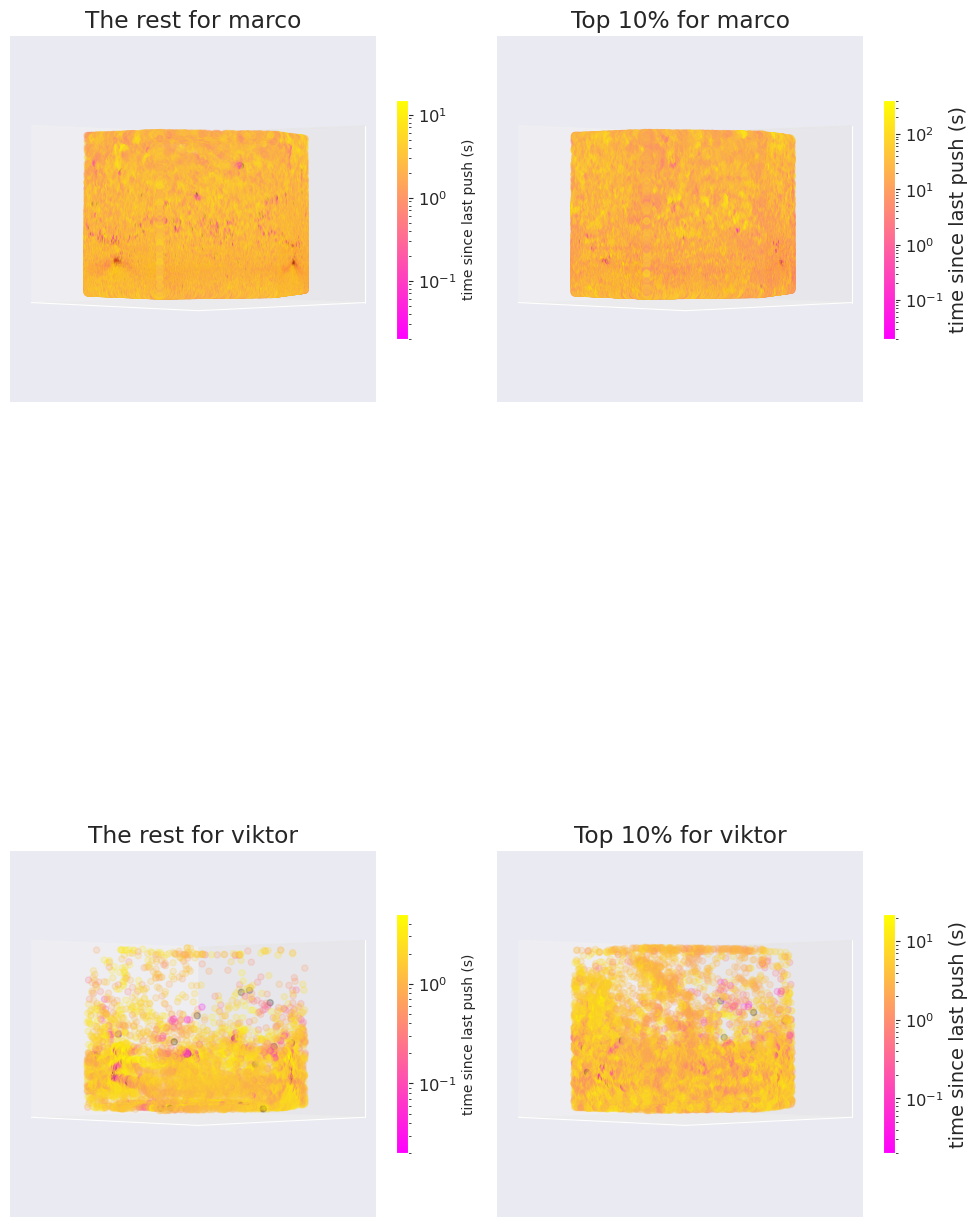

In [27]:
monkey_subjects_eye_tracking = ['marco', 'viktor']
fig = plt.figure(figsize=(10, 20))
for i, subject in enumerate(monkey_subjects_eye_tracking):
    df_subj = utils.data.filter_df(all_perc_df, {'subject': subject})

    # The rest
    ax = fig.add_subplot(2, 2, 2 * i + 1, projection='3d')
    ax1, p1 = plotting.behavior.plot_continuous3d_df(df_subj[df_subj['push percentiles'] < 0.9], continuous_data,
                                                     'eye_arena_int', title=f'The rest for {subject}',
                                                     plt_kwargs={'alpha': 0.2, 'cmap': 'spring', 'norm': LogNorm()},
                                                     cbar_kwargs={'shrink': 0.7, 'fraction': 0.03, 'alpha': 1}, ax=ax)
    c1 = p1.colorbar
    c1.set_label(c1.ax.get_ylabel(), fontsize=10)

    # Top 10%
    ax = fig.add_subplot(2, 2, 2 * i + 2, projection='3d', sharex=ax, sharey=ax, sharez=ax)
    ax2, p2 = plotting.behavior.plot_continuous3d_df(df_subj[df_subj['push percentiles'] >= 0.9], continuous_data,
                                                     'eye_arena_int', title=f'Top 10% for {subject}',
                                                     plt_kwargs={'alpha': 0.2, 'cmap': 'spring', 'norm': LogNorm()},
                                                     cbar_kwargs={'shrink': 0.7, 'fraction': 0.03, 'alpha': 1}, ax=ax)
    c2 = p1.colorbar
    c2.set_label(c2.ax.get_ylabel(), fontsize=10)
fig.tight_layout()

Dylan is not shown because he did not have eye tracking data. There is a weak relationship between the eye locations and time for both monkeys. Marco has clear hotspots of gaze locations at the boxes, where the hotspots correspond to time early on in the push interval and thus possibly occurring when Marco spam pushes. Meanwhile, Viktor doesn't seem to have these hotspots, instead his gaze seems to land on the boxes later in the push intervals, possibly when he's moving towards them. Also, his gaze sticks closer to the ground compared to when he's taking longer than usual to push.

# Clean Data

Taking all these observations into account, the following is a preliminary exclusion criteria:

+ remove all blocks with less than 10 pushes
+ remove all blocks where the schedules contain 80 s as one of the boxes
+ remove pushes greater than 50 s

This can be greatly expanded upon and refined through various data wrangling schemes, such as dimensionality reduction via PCA or t-SNE, and automated methods that we are currently developing. For now, this is a baseline criteria that serves as a starting point for more advanced analysis.

In [28]:
df_filtered = utils.data.exclusion_criteria(df)
print(f'Applying exclusion criteria dropped {len(df) - len(df_filtered)} pushes')

Applying exclusion criteria dropped 2471 pushes


Text(40.000000000000014, 0.5, 'consecutive push intervals (s)')

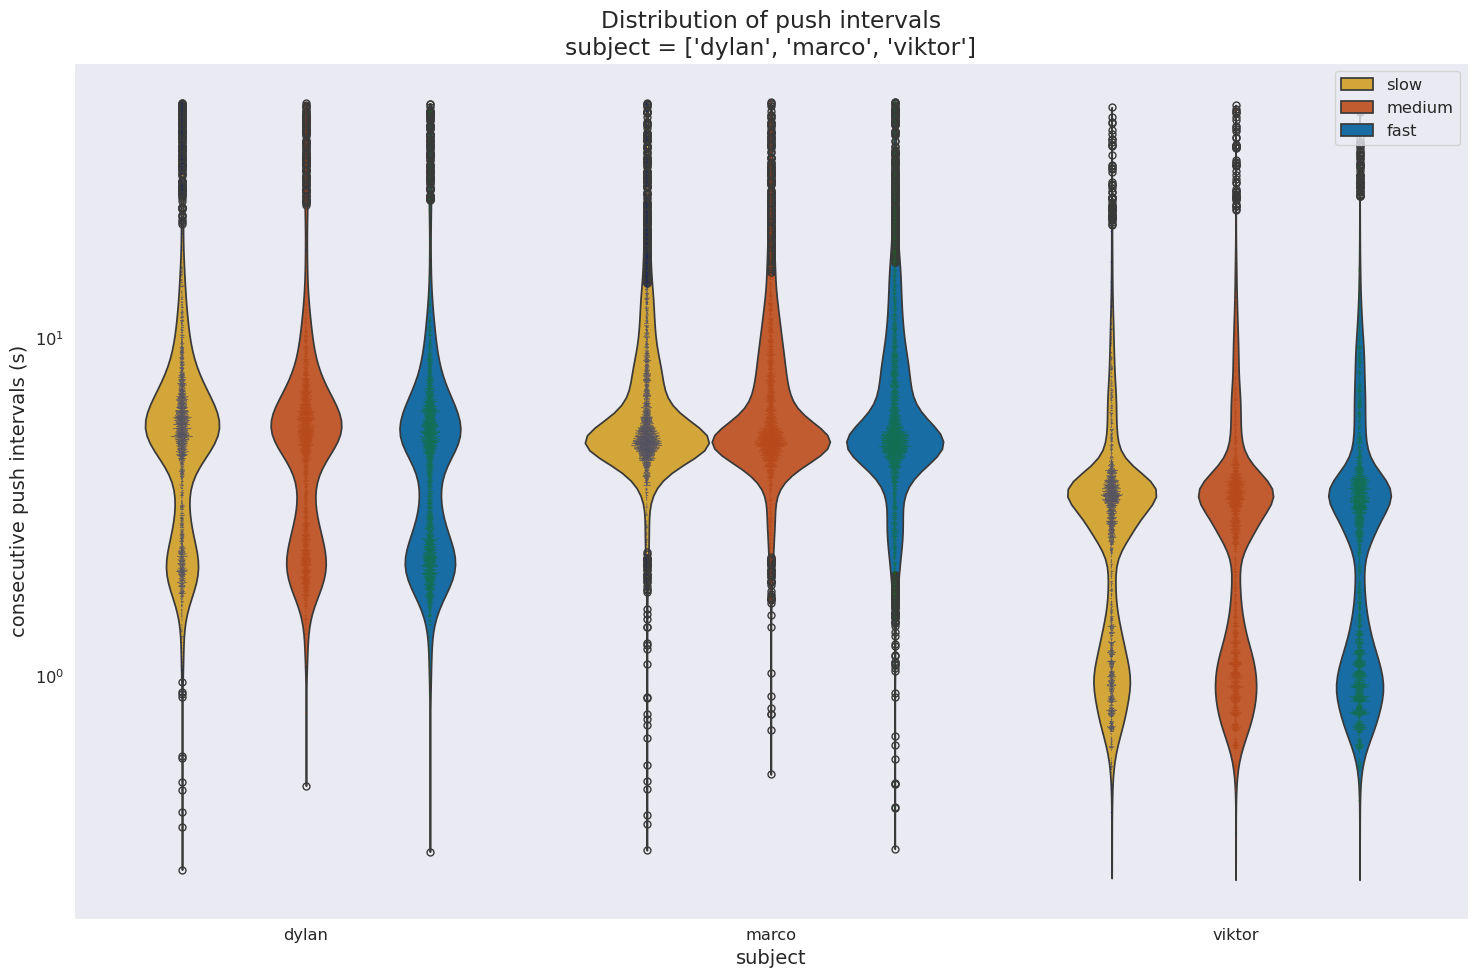

In [30]:
# examine monkeys separately from humans
conds = {'subject': ['dylan', 'marco', 'viktor']}
df_monkey = utils.data.filter_df(df_filtered, conds).copy(deep=True)

# plot distribution of push intervals on log-scale
fig, ax = plt.subplots()
bp(sns.boxplot)(df_monkey, conds=conds, x='subject', y='consecutive push intervals', collapse=True, showcaps=False,
                showbox=False, log_scale=True, whiskerprops={'visible': False}, medianprops={'visible': False},
                legend=False, ax=ax)
bp(sns.swarmplot)(df_monkey.groupby('subject').sample(10000, random_state=SEED), conds=conds, x='subject',
                  y='consecutive push intervals', collapse=True, legend=False, log_scale=True, size=0.5, dodge=True,
                  palette='dark', ax=ax)
bp(sns.violinplot)(df_monkey, conds=conds, x='subject', y='consecutive push intervals', collapse=True, cut=0,
                   inner=None, log_scale=True, common_norm=True, title_prefix="Distribution of push intervals", ax=ax)
ax.set_ylabel(ax.get_ylabel() + ' (s)')

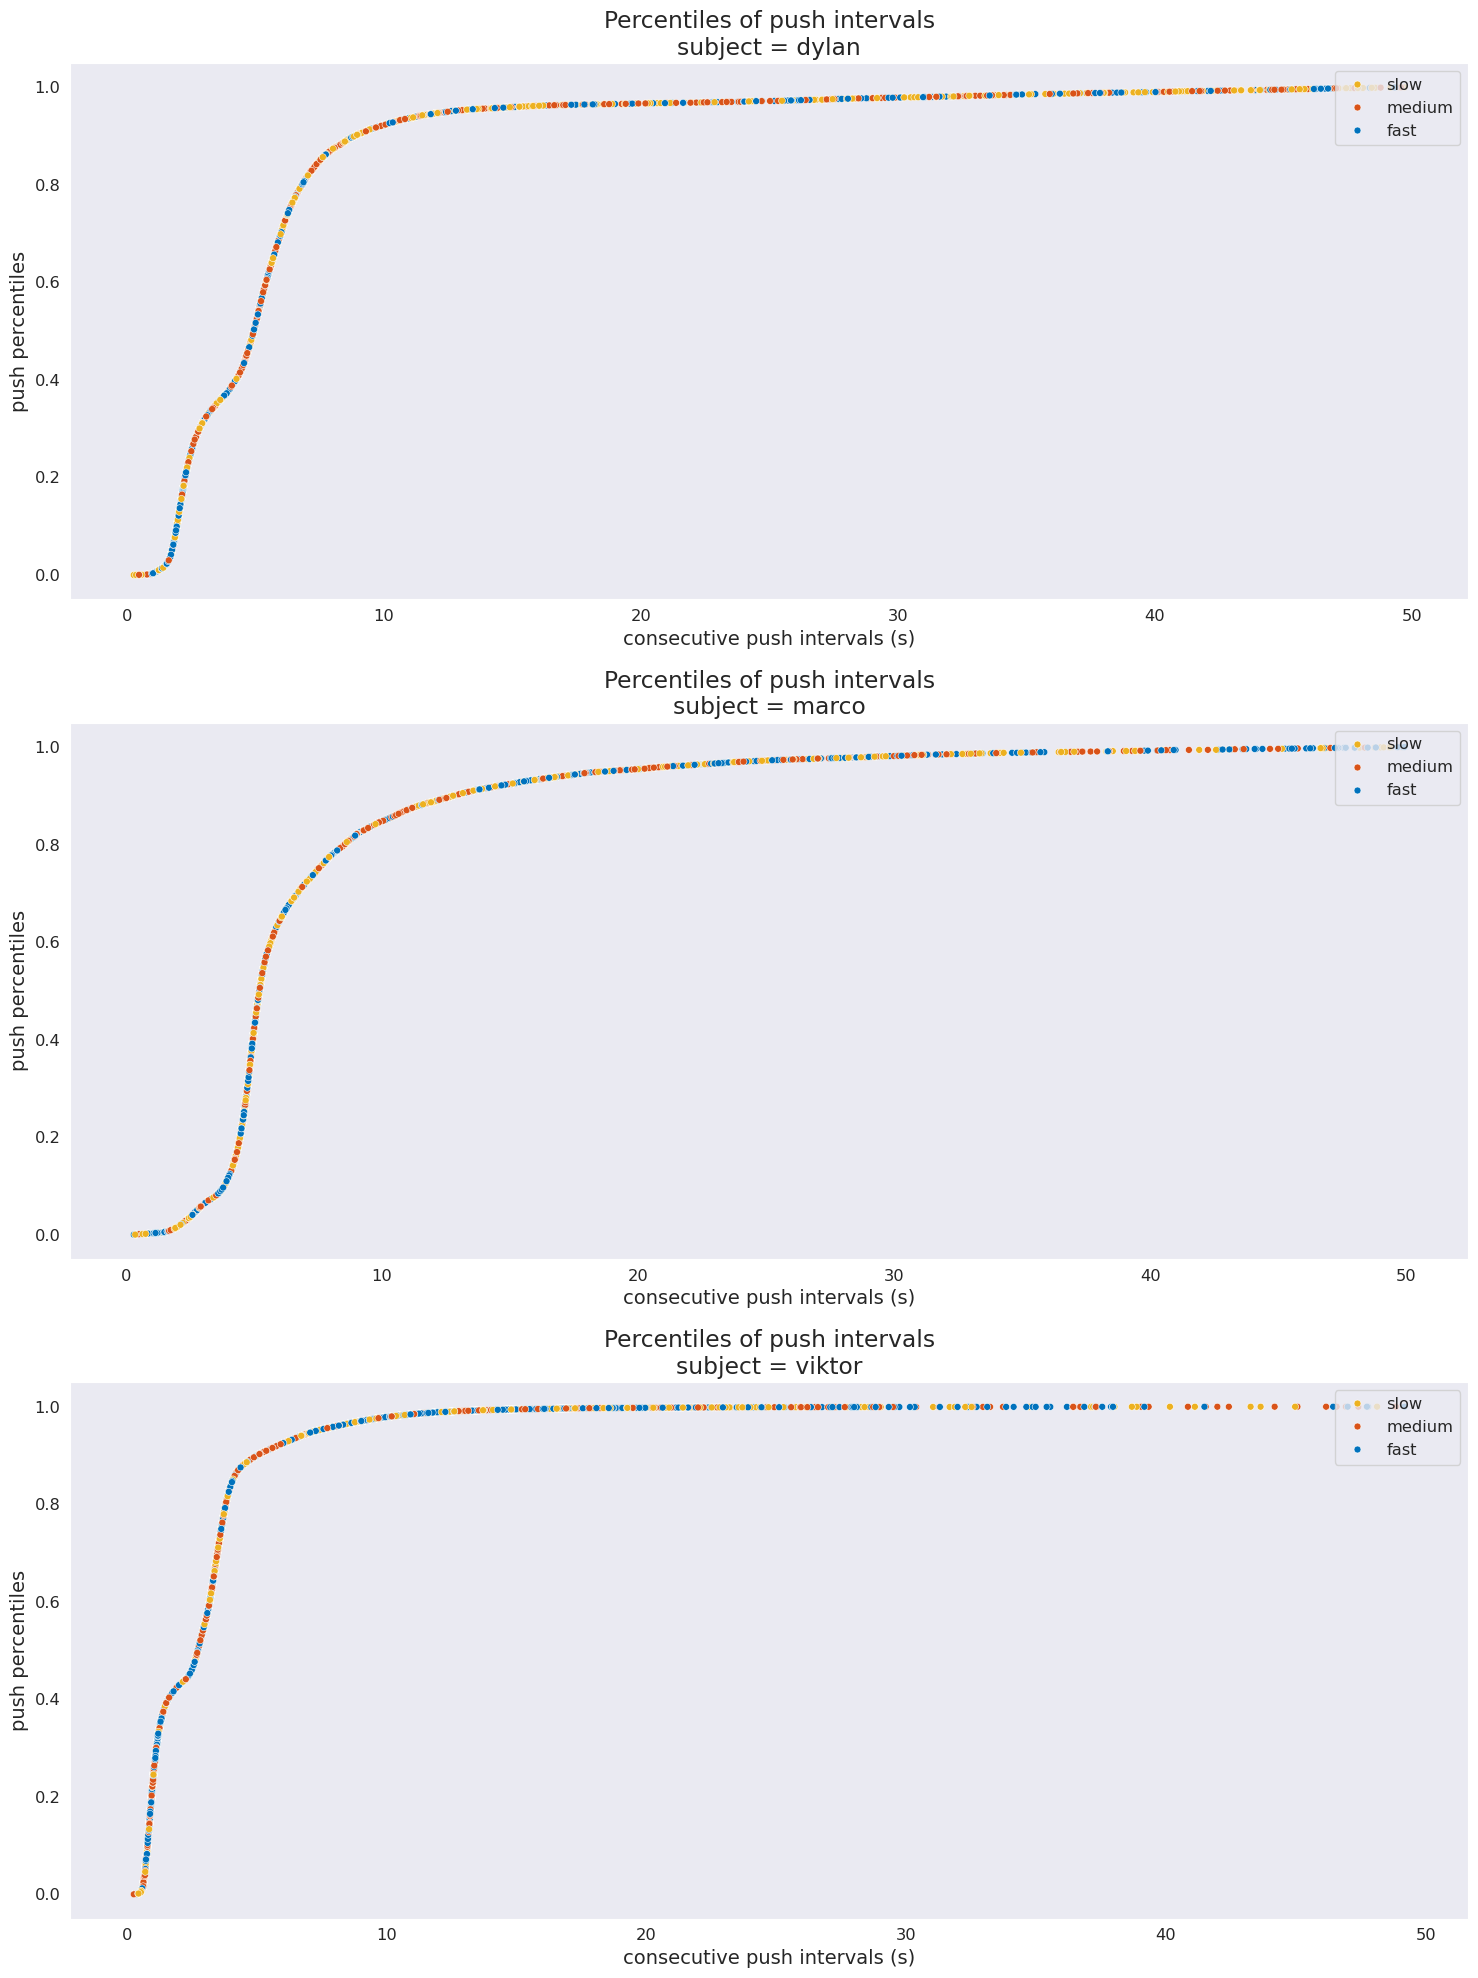

In [31]:
df_monkey['push percentiles'] = df_monkey.groupby('subject', as_index=False)['consecutive push intervals'].rank(
    pct=True)
monkey_subjects = df_monkey.index.unique('subject')
monkey_knees = {}
fig, axes = plt.subplots(len(monkey_subjects), 1, figsize=(15, 20))
for i, subj in enumerate(monkey_subjects):
    bp(sns.scatterplot)(df_monkey, x='consecutive push intervals', y='push percentiles', collapse=True,
                        conds={'subject': subj}, title_prefix="Percentiles of push intervals", ax=axes[i])
    y = df_monkey.loc[(subj,), 'push percentiles'].sort_values()
    x = df_monkey.loc[(subj,), 'consecutive push intervals'].sort_values()
    axes[i].set_xlabel(axes[i].get_xlabel() + ' (s)')
fig.tight_layout()

After removing the outliers for each subject, we see now that the push intervals are within a more reasonable range and cluster closer together.